In [1]:
!if [[ ! -d PROJECT ]] && [[ ! -d PIGEON ]]; then git clone https://github.com/iggy2k/CSC490-Project-Winter-2025.git PROJECT; fi

Cloning into 'PROJECT'...
remote: Enumerating objects: 446, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 446 (delta 46), reused 66 (delta 24), pack-reused 352 (from 1)
Receiving objects: 100% (446/446), 29.62 MiB | 14.51 MiB/s, done.
Resolving deltas: 100% (216/216), done.


In [2]:
import sys
import os
sys.path.append(os.path.abspath('./PROJECT'))

In [3]:
# Import setup module
from modules.setup import mount_drive, install_dependencies, extract_dataset

# Run setup steps
mount_drive()
install_dependencies()
extract_dataset()


Mounted at /content/drive
Google Drive mounted successfully.


  0%|          | 0/26 [00:00<?, ?it/s]

✅ Successfully installed fiona
✅ Successfully installed folium
✅ Successfully installed geopandas
✅ Successfully installed huggingface_hub
✅ Successfully installed ipython
✅ Successfully installed ipywidgets
✅ Successfully installed jinja2
✅ Successfully installed jupyter
✅ Successfully installed markupsafe
⚠️ Error installing matplotlib-base: Command 'pip install matplotlib-base' returned non-zero exit status 1.
✅ Successfully installed matplotlib-inline
✅ Successfully installed nbconvert
✅ Successfully installed nbformat
✅ Successfully installed notebook
✅ Successfully installed numpy
✅ Successfully installed pandas
✅ Successfully installed pip
✅ Successfully installed pynvml
⚠️ Error installing python: Command 'pip install python' returned non-zero exit status 1.
⚠️ Error installing pytorch: Command 'pip install pytorch' returned non-zero exit status 1.
✅ Successfully installed scikit-learn
✅ Successfully installed scipy
✅ Successfully installed torchvision
✅ Successfully installed 

In [2]:
# This is supposed to make sure if you edit .py files
# colab will pick up on it
%load_ext autoreload
%autoreload 2

In [4]:
from modules.dataset import ImageCoordinateDataset, download_osv5m_dataset, extract_zip_files
download_osv5m_dataset()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

00.zip:   0%|          | 0.00/2.52G [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/2.92G [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/116M [00:00<?, ?B/s]

00.zip:   0%|          | 0.00/2.25G [00:00<?, ?B/s]

In [5]:
extract_zip_files()

Extracting datasets/osv5m/images/test/00.zip:   0%|          | 0/50001 [00:00<?, ?it/s]

Extracting datasets/osv5m/images/train/00.zip:   0%|          | 0/50001 [00:00<?, ?it/s]

In [6]:
import torch
import torchvision.transforms as transforms
mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)
normalize = transforms.Normalize(mean.tolist(), std.tolist())

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

In [7]:
BATCH_SIZE = 32
MAX_ITEMS = 10000

In [8]:
train_dataset = ImageCoordinateDataset(csv_file='datasets/osv5m/train.csv', image_dirs=[
                                      'datasets/osv5m/images/train/00',
                                      ],\
                                 transform=transform)
val_dataset = ImageCoordinateDataset(csv_file='datasets/osv5m/test.csv', image_dirs=[
                                      'datasets/osv5m/images/test/00',
                                      ],\
                                 transform=transform)

Reading datasets/osv5m/images/train/00
Found 50000 files.


Loading data: 0it [00:00, ?it/s]

Found 4894684 csv entries.


Processing files:   0%|          | 0/50000 [00:00<?, ?it/s]

Keeping 10000 items
Dataset ready, 10000 files.
Skipped 0 non-land files.
Reading datasets/osv5m/images/test/00
Found 50000 files.


Loading data: 0it [00:00, ?it/s]

Found 210122 csv entries.


Processing files:   0%|          | 0/50000 [00:00<?, ?it/s]

Keeping 10000 items
Dataset ready, 10000 files.
Skipped 0 non-land files.


In [9]:
# Create dataloaders
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  print('using cuda')
else:
  device = torch.device("cpu")
  print('using cpu')

using cuda


In [11]:
CLIP_MODEL = 'openai/clip-vit-base-patch32'

In [12]:
# !pip install -q git+https://github.com/openai/CLIP.git

In [13]:
!mkdir -p data/geocells/
# Political boundaries (admin0 = country)
![ ! -f data/geocells/admin_2.geojson ] && wget --show-progress -O data/geocells/admin_2.geojson -q https://github.com/wmgeolab/geoBoundaries/raw/main/releaseData/CGAZ/geoBoundariesCGAZ_ADM2.geojson
![ ! -f data/geocells/admin_1.geojson ] && wget --show-progress -O data/geocells/admin_1.geojson -q https://github.com/wmgeolab/geoBoundaries/raw/main/releaseData/CGAZ/geoBoundariesCGAZ_ADM1.geojson
![ ! -f data/geocells/countries.geojson ] && wget --show-progress -O data/geocells/countries.geojson -q https://github.com/wmgeolab/geoBoundaries/raw/main/releaseData/CGAZ/geoBoundariesCGAZ_ADM0.geojson

In [14]:
!pip install -q geojson

In [15]:
from modules.geocell import hook, simplify_geojson

In [16]:
import os
import sys

# Local
if os.path.isdir('PIGEON/'):
    PIGEON_DIR = 'PIGEON/'
# Git clone when colab
else:
    PIGEON_DIR = 'PROJECT/PIGEON/'

os.environ["PIGEON_DIR"] = PIGEON_DIR
sys.path.insert(1, PIGEON_DIR)

In [17]:
from pathlib import Path

SIMPLIFY_GEOJSON = True

if SIMPLIFY_GEOJSON:
    print('Simplifying geojson file for faster geocell gen...')

    new_admin1 = simplify_geojson('data/geocells/admin_1.geojson', 2.5)
    new_admin2 = simplify_geojson('data/geocells/admin_2.geojson', 2.5)
    new_countries = simplify_geojson('data/geocells/countries.geojson', 2.5)

    COUNTRY_PATH = 'data/geocells/countries.geojson_compressed_2.5.geojson'
    ADMIN_1_PATH = 'data/geocells/admin_1.geojson_compressed_2.5.geojson'
    ADMIN_2_PATH = 'data/geocells/admin_2.geojson_compressed_2.5.geojson'

    print('New geojson files:', COUNTRY_PATH, ADMIN_1_PATH, ADMIN_2_PATH)

Simplifying geojson file for faster geocell gen...
data/geocells/admin_1.geojson_compressed_2.5.geojson alredy exists, skipping...
data/geocells/admin_2.geojson_compressed_2.5.geojson alredy exists, skipping...
data/geocells/countries.geojson_compressed_2.5.geojson alredy exists, skipping...
New geojson files: data/geocells/countries.geojson_compressed_2.5.geojson data/geocells/admin_1.geojson_compressed_2.5.geojson data/geocells/admin_2.geojson_compressed_2.5.geojson


In [18]:
# TODO: pre-generate all this, add to the repo and add option to load instead
import sys
sys.path.append(f'{PIGEON_DIR}/dataset_creation/geocell')
sys.path.append(PIGEON_DIR)

from geocell_creation import *

GEOCELL_PATH = 'data/geocells_yfcc.csv'
df = train_dataset.df
geocells_file = Path(GEOCELL_PATH)
if not geocells_file.is_file():
    geocell_creator = GeocellCreator(df, GEOCELL_PATH)
    geocells = geocell_creator.generate()
else:
  print('Loading existing geocells')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Loading existing geocells


In [19]:
# Use to load anything to your google drive
from google.colab import drive
drive.mount('/content/drive')
!tar -zcf 490data.tar.gz ./data
!cp 490data.tar.gz /content/drive/My\ Drive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
!pip install -q huggingface-hub transformers pygeos
!pip install -q -U dill datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.1 MB/s eta 0:00:00


In [21]:
from accelerate import Accelerator
accelerator = Accelerator()

In [22]:
from modules.model import GeoLocationModel

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [23]:
from modules.loss import HaversineLoss

In [25]:
import torch.optim as optim

from torch.optim.lr_scheduler import ExponentialLR

haversineLoss = HaversineLoss()
# mseLoss = nn.MSELoss()
# ceLoss = nn.CrossEntropyLoss()
model = GeoLocationModel()

optimizer = optim.SGD(model.parameters(), lr=0.001)
scheduler = ExponentialLR(optimizer, gamma=0.8)

In [26]:
!pip install -q livelossplot

In [27]:
from livelossplot import PlotLosses

In [28]:
from ipywidgets import Output
OUTPUT_CONTEXT = Output()
display(OUTPUT_CONTEXT)

Output()

In [29]:
# Clean-up if re-running
model = GeoLocationModel()
torch.cuda.empty_cache()

In [30]:
from modules.train import train_model
from accelerate import Accelerator

# Initialize necessary components
accelerator = Accelerator()

# Call the function
avg_epoch_loss = train_model(
    model=model,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    accelerator=accelerator,
    scheduler=scheduler,
    num_epochs=1,
    haversineLoss=haversineLoss,
    OUTPUT_CONTEXT=OUTPUT_CONTEXT
)

Setting figsize to (10, 5)


Epoch 1 progress:   0%|          | 0/313 [00:00<?, ?it/s]

Epochs:   0%|          | 0/1 [00:01<?, ?it/s]

Loss: 0.74835;                         
Out: [42.18771333296962, 22.752994258399557]                        
Expected: [36.840965270996094, 20.629581451416016]



Epoch 1 progress:   0%|          | 1/313 [00:02<11:53,  2.29s/it]

Epochs:   0%|          | 0/1 [00:02<?, ?it/s]

Loss: 0.76265;                         
Out: [45.58972556322606, 24.19915044490709]                        
Expected: [31.265979766845703, -5.056425094604492]



Epoch 1 progress:   1%|          | 2/313 [00:03<07:36,  1.47s/it]

Epochs:   0%|          | 0/1 [00:03<?, ?it/s]

Loss: 0.74640;                         
Out: [45.693074167017464, 21.047770313231666]                        
Expected: [35.18977355957031, 2.722561836242676]



Epoch 1 progress:   1%|          | 3/313 [00:04<06:28,  1.25s/it]

Epochs:   0%|          | 0/1 [00:04<?, ?it/s]

Loss: 0.74820;                         
Out: [38.18992008150948, 28.210196854571493]                        
Expected: [37.000484466552734, -4.234860897064209]



Epoch 1 progress:   1%|▏         | 4/313 [00:05<05:50,  1.13s/it]

Epochs:   0%|          | 0/1 [00:05<?, ?it/s]

Loss: 0.67578;                         
Out: [15.689304536004027, 20.88345500268671]                        
Expected: [31.49534797668457, 28.888771057128906]



Epoch 1 progress:   2%|▏         | 5/313 [00:06<05:20,  1.04s/it]

Epochs:   0%|          | 0/1 [00:06<?, ?it/s]

Loss: 0.67022;                         
Out: [44.89501706375681, 24.193374419131757]                        
Expected: [34.481658935546875, -3.686793804168701]



Epoch 1 progress:   2%|▏         | 6/313 [00:06<05:01,  1.02it/s]

Epochs:   0%|          | 0/1 [00:07<?, ?it/s]

Loss: 0.89281;                         
Out: [15.805952419140375, 15.370499078405677]                        
Expected: [34.823360443115234, -11.467771530151367]



Epoch 1 progress:   2%|▏         | 7/313 [00:07<04:43,  1.08it/s]

Epochs:   0%|          | 0/1 [00:08<?, ?it/s]

Loss: 0.81377;                         
Out: [38.16710215572614, 8.932036637511882]                        
Expected: [38.01322937011719, 4.938121318817139]



Epoch 1 progress:   3%|▎         | 8/313 [00:08<04:35,  1.11it/s]

Epochs:   0%|          | 0/1 [00:09<?, ?it/s]

Loss: 0.78880;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [33.28102493286133, -11.557977676391602]



Epoch 1 progress:   3%|▎         | 9/313 [00:09<04:32,  1.12it/s]

Epochs:   0%|          | 0/1 [00:10<?, ?it/s]

Loss: 0.78731;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [32.83610916137695, -14.218701362609863]



Epoch 1 progress:   3%|▎         | 10/313 [00:10<04:27,  1.13it/s]

Epochs:   0%|          | 0/1 [00:10<?, ?it/s]

Loss: 0.79390;                         
Out: [37.75476920241801, 8.35734459773901]                        
Expected: [35.35525131225586, -13.131158828735352]



Epoch 1 progress:   4%|▎         | 11/313 [00:11<04:20,  1.16it/s]

Epochs:   0%|          | 0/1 [00:11<?, ?it/s]

Loss: 0.75440;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [38.88349914550781, -16.889028549194336]



Epoch 1 progress:   4%|▍         | 12/313 [00:11<04:15,  1.18it/s]

Epochs:   0%|          | 0/1 [00:12<?, ?it/s]

Loss: 0.74689;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [29.906543731689453, -0.1970820426940918]



Epoch 1 progress:   4%|▍         | 13/313 [00:12<04:14,  1.18it/s]

Epochs:   0%|          | 0/1 [00:13<?, ?it/s]

Loss: 0.78461;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [31.661073684692383, -1.1753172874450684]



Epoch 1 progress:   4%|▍         | 14/313 [00:13<04:13,  1.18it/s]

Epochs:   0%|          | 0/1 [00:14<?, ?it/s]

Loss: 0.77764;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [34.75440979003906, 4.148064613342285]



Epoch 1 progress:   5%|▍         | 15/313 [00:14<04:11,  1.18it/s]

Epochs:   0%|          | 0/1 [00:14<?, ?it/s]

Loss: 0.63567;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [35.58549499511719, -7.819916725158691]



Epoch 1 progress:   5%|▌         | 16/313 [00:15<04:08,  1.19it/s]

Epochs:   0%|          | 0/1 [00:15<?, ?it/s]

Loss: 0.82156;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [32.86798095703125, -1.1383988857269287]



Epoch 1 progress:   5%|▌         | 17/313 [00:16<04:07,  1.19it/s]

Epochs:   0%|          | 0/1 [00:16<?, ?it/s]

Loss: 0.79351;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [37.91022872924805, -14.180830955505371]



Epoch 1 progress:   6%|▌         | 18/313 [00:16<04:04,  1.20it/s]

Epochs:   0%|          | 0/1 [00:17<?, ?it/s]

Loss: 0.71452;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [27.575904846191406, -0.15318357944488525]



Epoch 1 progress:   6%|▌         | 19/313 [00:17<04:03,  1.21it/s]

Epochs:   0%|          | 0/1 [00:18<?, ?it/s]

Loss: 0.83368;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [37.29002380371094, 24.778839111328125]



Epoch 1 progress:   6%|▋         | 20/313 [00:18<04:01,  1.22it/s]

Epochs:   0%|          | 0/1 [00:19<?, ?it/s]

Loss: 0.77309;                         
Out: [37.99253805715874, 8.249267949987228]                        
Expected: [36.38080978393555, -0.5208110809326172]



Epoch 1 progress:   7%|▋         | 21/313 [00:19<04:04,  1.20it/s]

Epochs:   0%|          | 0/1 [00:19<?, ?it/s]

Loss: 0.82905;                         
Out: [37.99253805715873, 8.249267949987228]                        
Expected: [25.732975006103516, 24.672962188720703]



Epoch 1 progress:   7%|▋         | 22/313 [00:20<03:59,  1.21it/s]

Epochs:   0%|          | 0/1 [00:20<?, ?it/s]

Loss: 0.84492;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [29.356693267822266, -18.121850967407227]



Epoch 1 progress:   7%|▋         | 23/313 [00:21<03:58,  1.21it/s]

Epochs:   0%|          | 0/1 [00:21<?, ?it/s]

Loss: 0.80594;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [37.346778869628906, -26.116737365722656]



Epoch 1 progress:   8%|▊         | 24/313 [00:21<03:57,  1.21it/s]

Epochs:   0%|          | 0/1 [00:22<?, ?it/s]

Loss: 0.75787;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [37.911502838134766, 8.710770606994629]



Epoch 1 progress:   8%|▊         | 25/313 [00:22<03:59,  1.20it/s]

Epochs:   0%|          | 0/1 [00:23<?, ?it/s]

Loss: 0.73539;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [36.28798294067383, 9.284698486328125]



Epoch 1 progress:   8%|▊         | 26/313 [00:24<04:42,  1.02it/s]

Epochs:   0%|          | 0/1 [00:24<?, ?it/s]

Loss: 0.68691;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [30.09830665588379, 6.13688325881958]



Epoch 1 progress:   9%|▊         | 27/313 [00:24<04:25,  1.08it/s]

Epochs:   0%|          | 0/1 [00:25<?, ?it/s]

Loss: 0.85443;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [34.45528793334961, 22.870189666748047]



Epoch 1 progress:   9%|▉         | 28/313 [00:25<04:13,  1.13it/s]

Epochs:   0%|          | 0/1 [00:26<?, ?it/s]

Loss: 0.74654;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [31.201587677001953, -21.978271484375]



Epoch 1 progress:   9%|▉         | 29/313 [00:26<04:05,  1.16it/s]

Epochs:   0%|          | 0/1 [00:27<?, ?it/s]

Loss: 0.70036;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [34.74004364013672, -21.351049423217773]



Epoch 1 progress:  10%|▉         | 30/313 [00:27<04:01,  1.17it/s]

Epochs:   0%|          | 0/1 [00:27<?, ?it/s]

Loss: 0.73310;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [35.57414627075195, -23.296714782714844]



Epoch 1 progress:  10%|▉         | 31/313 [00:28<03:59,  1.18it/s]

Epochs:   0%|          | 0/1 [00:28<?, ?it/s]

Loss: 0.88253;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [32.0084228515625, 2.531047821044922]



Epoch 1 progress:  10%|█         | 32/313 [00:28<03:56,  1.19it/s]

Epochs:   0%|          | 0/1 [00:29<?, ?it/s]

Loss: 0.78410;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [25.40699577331543, 3.1700186729431152]



Epoch 1 progress:  11%|█         | 33/313 [00:29<03:53,  1.20it/s]

Epochs:   0%|          | 0/1 [00:30<?, ?it/s]

Loss: 0.83027;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [27.75031852722168, 21.05591583251953]



Epoch 1 progress:  11%|█         | 34/313 [00:30<03:50,  1.21it/s]

Epochs:   0%|          | 0/1 [00:31<?, ?it/s]

Loss: 0.75136;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [29.659677505493164, -8.619210243225098]



Epoch 1 progress:  11%|█         | 35/313 [00:31<03:48,  1.21it/s]

Epochs:   0%|          | 0/1 [00:31<?, ?it/s]

Loss: 0.84401;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [30.37405776977539, 3.875389814376831]



Epoch 1 progress:  12%|█▏        | 36/313 [00:32<03:47,  1.22it/s]

Epochs:   0%|          | 0/1 [00:32<?, ?it/s]

Loss: 0.84817;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [36.18986892700195, -18.083559036254883]



Epoch 1 progress:  12%|█▏        | 37/313 [00:33<03:50,  1.20it/s]

Epochs:   0%|          | 0/1 [00:33<?, ?it/s]

Loss: 0.68986;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [32.973602294921875, -33.15902328491211]



Epoch 1 progress:  12%|█▏        | 38/313 [00:33<03:58,  1.15it/s]

Epochs:   0%|          | 0/1 [00:34<?, ?it/s]

Loss: 0.73464;                         
Out: [29.620083108264875, -20.842302494161988]                        
Expected: [33.75328826904297, -1.1572446823120117]



Epoch 1 progress:  12%|█▏        | 39/313 [00:35<04:10,  1.10it/s]

Epochs:   0%|          | 0/1 [00:35<?, ?it/s]

Loss: 0.77407;                         
Out: [32.76853376211917, -2.5989219285023966]                        
Expected: [34.87466812133789, -8.789161682128906]



Epoch 1 progress:  13%|█▎        | 40/313 [00:35<04:01,  1.13it/s]

Epochs:   0%|          | 0/1 [00:36<?, ?it/s]

Loss: 0.70136;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [33.84197998046875, 18.639148712158203]



Epoch 1 progress:  13%|█▎        | 41/313 [00:36<03:55,  1.16it/s]

Epochs:   0%|          | 0/1 [00:37<?, ?it/s]

Loss: 0.79063;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [38.70564651489258, -1.7192447185516357]



Epoch 1 progress:  13%|█▎        | 42/313 [00:37<03:49,  1.18it/s]

Epochs:   0%|          | 0/1 [00:38<?, ?it/s]

Loss: 0.85586;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [35.85056686401367, -16.203140258789062]



Epoch 1 progress:  14%|█▎        | 43/313 [00:38<03:45,  1.20it/s]

Epochs:   0%|          | 0/1 [00:38<?, ?it/s]

Loss: 0.82639;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [35.81268310546875, -15.286376953125]



Epoch 1 progress:  14%|█▍        | 44/313 [00:39<03:42,  1.21it/s]

Epochs:   0%|          | 0/1 [00:39<?, ?it/s]

Loss: 0.79398;                         
Out: [32.76853376211916, -2.5989219285023957]                        
Expected: [30.029573440551758, 3.6149940490722656]



Epoch 1 progress:  14%|█▍        | 45/313 [00:39<03:39,  1.22it/s]

Epochs:   0%|          | 0/1 [00:40<?, ?it/s]

Loss: 0.77540;                         
Out: [21.905515355516208, -27.255161333865168]                        
Expected: [28.08194351196289, -17.594139099121094]



Epoch 1 progress:  15%|█▍        | 46/313 [00:40<03:39,  1.21it/s]

Epochs:   0%|          | 0/1 [00:41<?, ?it/s]

Loss: 0.74064;                         
Out: [29.90984470774997, -9.087405982545231]                        
Expected: [31.20994758605957, -17.82857894897461]



Epoch 1 progress:  15%|█▌        | 47/313 [00:41<03:39,  1.21it/s]

Epochs:   0%|          | 0/1 [00:42<?, ?it/s]

Loss: 0.80670;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [37.88899230957031, -11.778264999389648]



Epoch 1 progress:  15%|█▌        | 48/313 [00:42<03:38,  1.21it/s]

Epochs:   0%|          | 0/1 [00:42<?, ?it/s]

Loss: 0.72121;                         
Out: [20.762039733768525, -29.850554955482302]                        
Expected: [34.95417404174805, 4.894050598144531]



Epoch 1 progress:  16%|█▌        | 49/313 [00:43<03:38,  1.21it/s]

Epochs:   0%|          | 0/1 [00:43<?, ?it/s]

Loss: 0.68315;                         
Out: [33.912009383866845, -0.003528306885262067]                        
Expected: [38.32160949707031, -8.917550086975098]



Epoch 1 progress:  16%|█▌        | 50/313 [00:44<03:38,  1.21it/s]

Epochs:   0%|          | 0/1 [00:44<?, ?it/s]

Loss: 0.80957;                         
Out: [32.76853376211917, -2.5989219285023974]                        
Expected: [35.37968444824219, -4.111527919769287]



Epoch 1 progress:  16%|█▋        | 51/313 [00:44<03:37,  1.20it/s]

Epochs:   0%|          | 0/1 [00:45<?, ?it/s]

Loss: 0.68568;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [37.16828918457031, -8.747876167297363]



Epoch 1 progress:  17%|█▋        | 52/313 [00:45<03:38,  1.19it/s]

Epochs:   0%|          | 0/1 [00:46<?, ?it/s]

Loss: 0.74997;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [34.046531677246094, 10.867568969726562]



Epoch 1 progress:  17%|█▋        | 53/313 [00:46<03:40,  1.18it/s]

Epochs:   0%|          | 0/1 [00:47<?, ?it/s]

Loss: 0.72430;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [36.744293212890625, -21.692651748657227]



Epoch 1 progress:  17%|█▋        | 54/313 [00:47<03:42,  1.16it/s]

Epochs:   0%|          | 0/1 [00:48<?, ?it/s]

Loss: 0.75710;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [30.412357330322266, -16.247920989990234]



Epoch 1 progress:  18%|█▊        | 55/313 [00:48<03:39,  1.18it/s]

Epochs:   0%|          | 0/1 [00:48<?, ?it/s]

Loss: 0.70304;                         
Out: [28.194631275128447, -12.980496414970931]                        
Expected: [37.62446212768555, -3.9445135593414307]



Epoch 1 progress:  18%|█▊        | 56/313 [00:49<03:37,  1.18it/s]

Epochs:   0%|          | 0/1 [00:49<?, ?it/s]

Loss: 0.74450;                         
Out: [33.34027157299301, -1.3012251176938299]                        
Expected: [22.709728240966797, -0.08361303806304932]



Epoch 1 progress:  18%|█▊        | 57/313 [00:49<03:34,  1.19it/s]

Epochs:   0%|          | 0/1 [00:50<?, ?it/s]

Loss: 0.84992;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [34.58250427246094, -13.571121215820312]



Epoch 1 progress:  19%|█▊        | 58/313 [00:50<03:31,  1.20it/s]

Epochs:   0%|          | 0/1 [00:51<?, ?it/s]

Loss: 0.85514;                         
Out: [37.99253805715873, 8.249267949987228]                        
Expected: [35.321083068847656, -6.7041730880737305]



Epoch 1 progress:  19%|█▉        | 59/313 [00:52<04:14,  1.00s/it]

Epochs:   0%|          | 0/1 [00:52<?, ?it/s]

Loss: 0.82286;                         
Out: [35.05548500561453, 2.591865314731871]                        
Expected: [37.734779357910156, 2.0197906494140625]



Epoch 1 progress:  19%|█▉        | 60/313 [00:53<04:00,  1.05it/s]

Epochs:   0%|          | 0/1 [00:53<?, ?it/s]

Loss: 0.71405;                         
Out: [37.99253805715873, 8.249267949987228]                        
Expected: [34.01215744018555, -3.153003454208374]



Epoch 1 progress:  19%|█▉        | 61/313 [00:53<03:52,  1.08it/s]

Epochs:   0%|          | 0/1 [00:54<?, ?it/s]

Loss: 0.80990;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [24.616771697998047, -9.191120147705078]



Epoch 1 progress:  20%|█▉        | 62/313 [00:54<03:44,  1.12it/s]

Epochs:   0%|          | 0/1 [00:55<?, ?it/s]

Loss: 0.81789;                         
Out: [24.76420440988541, -20.766677279822332]                        
Expected: [37.070701599121094, 5.6789703369140625]



Epoch 1 progress:  20%|██        | 63/313 [00:55<03:39,  1.14it/s]

Epochs:   0%|          | 0/1 [00:56<?, ?it/s]

Loss: 0.88857;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [27.010875701904297, 10.008397102355957]



Epoch 1 progress:  20%|██        | 64/313 [00:56<03:35,  1.15it/s]

Epochs:   0%|          | 0/1 [00:56<?, ?it/s]

Loss: 0.83008;                         
Out: [31.625058140371493, -5.19431555011953]                        
Expected: [32.481327056884766, -6.411679267883301]



Epoch 1 progress:  21%|██        | 65/313 [00:57<03:32,  1.16it/s]

Epochs:   0%|          | 0/1 [00:57<?, ?it/s]

Loss: 0.77712;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [35.56887435913086, 4.281516075134277]



Epoch 1 progress:  21%|██        | 66/313 [00:58<03:35,  1.15it/s]

Epochs:   0%|          | 0/1 [00:58<?, ?it/s]

Loss: 0.88461;                         
Out: [36.770698438236046, 6.484955747157572]                        
Expected: [36.536869049072266, -14.660290718078613]



Epoch 1 progress:  21%|██▏       | 67/313 [00:59<03:35,  1.14it/s]

Epochs:   0%|          | 0/1 [00:59<?, ?it/s]

Loss: 0.79153;                         
Out: [19.046826301147004, -33.743645387908]                        
Expected: [31.0826358795166, 4.616171836853027]



Epoch 1 progress:  22%|██▏       | 68/313 [00:59<03:34,  1.14it/s]

Epochs:   0%|          | 0/1 [01:00<?, ?it/s]

Loss: 0.90379;                         
Out: [117.8796137013579, -31.36305924227542]                        
Expected: [28.433988571166992, 1.6831257343292236]



Epoch 1 progress:  22%|██▏       | 69/313 [01:00<03:31,  1.16it/s]

Epochs:   0%|          | 0/1 [01:01<?, ?it/s]

Loss: 0.71287;                         
Out: [34.48374719474069, 1.294168503923304]                        
Expected: [30.909709930419922, -3.3003101348876953]



Epoch 1 progress:  22%|██▏       | 70/313 [01:01<03:28,  1.16it/s]

Epochs:   0%|          | 0/1 [01:02<?, ?it/s]

Loss: 0.81808;                         
Out: [19.046826301147004, -33.743645387908]                        
Expected: [34.49267578125, -20.14498519897461]



Epoch 1 progress:  23%|██▎       | 71/313 [01:02<03:26,  1.17it/s]

Epochs:   0%|          | 0/1 [01:02<?, ?it/s]

Loss: 0.82945;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [31.687294006347656, -4.0842156410217285]



Epoch 1 progress:  23%|██▎       | 72/313 [01:03<03:24,  1.18it/s]

Epochs:   0%|          | 0/1 [01:03<?, ?it/s]

Loss: 0.69366;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [26.53597640991211, 20.70983123779297]



Epoch 1 progress:  23%|██▎       | 73/313 [01:04<03:23,  1.18it/s]

Epochs:   0%|          | 0/1 [01:04<?, ?it/s]

Loss: 0.87069;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [43.730224609375, -6.5262770652771]



Epoch 1 progress:  24%|██▎       | 74/313 [01:04<03:22,  1.18it/s]

Epochs:   0%|          | 0/1 [01:05<?, ?it/s]

Loss: 0.86281;                         
Out: [31.053320329497648, -6.492012360928096]                        
Expected: [34.09296417236328, -6.635383605957031]



Epoch 1 progress:  24%|██▍       | 75/313 [01:05<03:20,  1.18it/s]

Epochs:   0%|          | 0/1 [01:06<?, ?it/s]

Loss: 0.77116;                         
Out: [36.770698438236046, 6.484955747157572]                        
Expected: [30.54636001586914, -19.62697410583496]



Epoch 1 progress:  24%|██▍       | 76/313 [01:06<03:20,  1.18it/s]

Epochs:   0%|          | 0/1 [01:07<?, ?it/s]

Loss: 0.63271;                         
Out: [28.766369086002285, -11.682799604162364]                        
Expected: [24.145801544189453, -5.573883533477783]



Epoch 1 progress:  25%|██▍       | 77/313 [01:07<03:20,  1.18it/s]

Epochs:   0%|          | 0/1 [01:08<?, ?it/s]

Loss: 0.84548;                         
Out: [20.190301922894683, -31.14825176629087]                        
Expected: [38.20341110229492, 0.7196893692016602]



Epoch 1 progress:  25%|██▍       | 78/313 [01:08<03:22,  1.16it/s]

Epochs:   0%|          | 0/1 [01:08<?, ?it/s]

Loss: 0.75230;                         
Out: [24.270830596186574, -22.895455509418376]                        
Expected: [34.533714294433594, -1.4344501495361328]



Epoch 1 progress:  25%|██▌       | 79/313 [01:09<03:23,  1.15it/s]

Epochs:   0%|          | 0/1 [01:09<?, ?it/s]

Loss: 0.74815;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [33.694366455078125, -53.895896911621094]



Epoch 1 progress:  26%|██▌       | 80/313 [01:10<03:22,  1.15it/s]

Epochs:   0%|          | 0/1 [01:10<?, ?it/s]

Loss: 0.75709;                         
Out: [19.046826301147004, -33.743645387908]                        
Expected: [24.074947357177734, 0.7857723236083984]



Epoch 1 progress:  26%|██▌       | 81/313 [01:11<03:24,  1.13it/s]

Epochs:   0%|          | 0/1 [01:11<?, ?it/s]

Loss: 0.80061;                         
Out: [19.046826301147004, -33.743645387908]                        
Expected: [30.377384185791016, -9.298900604248047]



Epoch 1 progress:  26%|██▌       | 82/313 [01:11<03:28,  1.11it/s]

Epochs:   0%|          | 0/1 [01:12<?, ?it/s]

Loss: 0.71047;                         
Out: [19.046826301147004, -33.743645387908]                        
Expected: [25.105459213256836, -12.84678840637207]



Epoch 1 progress:  27%|██▋       | 83/313 [01:12<03:28,  1.10it/s]

Epochs:   0%|          | 0/1 [01:13<?, ?it/s]

Loss: 0.75712;                         
Out: [19.046826301147004, -33.743645387908]                        
Expected: [35.43889617919922, 3.5140891075134277]



Epoch 1 progress:  27%|██▋       | 84/313 [01:13<03:30,  1.09it/s]

Epochs:   0%|          | 0/1 [01:14<?, ?it/s]

Loss: 0.76558;                         
Out: [20.762039733768525, -29.850554955482302]                        
Expected: [33.38051986694336, -5.766037464141846]



Epoch 1 progress:  27%|██▋       | 85/313 [01:14<03:35,  1.06it/s]

Epochs:   0%|          | 0/1 [01:15<?, ?it/s]

Loss: 0.78616;                         
Out: [25.33594222075925, -19.468980469013765]                        
Expected: [39.17327880859375, -17.888137817382812]



Epoch 1 progress:  27%|██▋       | 86/313 [01:15<03:31,  1.07it/s]

Epochs:   0%|          | 0/1 [01:16<?, ?it/s]

Loss: 0.72014;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [29.720943450927734, -7.94033145904541]



Epoch 1 progress:  28%|██▊       | 87/313 [01:16<03:27,  1.09it/s]

Epochs:   0%|          | 0/1 [01:17<?, ?it/s]

Loss: 0.82740;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [38.01041030883789, -11.215446472167969]



Epoch 1 progress:  28%|██▊       | 88/313 [01:17<03:20,  1.12it/s]

Epochs:   0%|          | 0/1 [01:18<?, ?it/s]

Loss: 0.81922;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [35.133819580078125, 8.689708709716797]



Epoch 1 progress:  28%|██▊       | 89/313 [01:18<03:15,  1.15it/s]

Epochs:   0%|          | 0/1 [01:18<?, ?it/s]

Loss: 0.80110;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [40.32587432861328, -4.421980857849121]



Epoch 1 progress:  29%|██▉       | 90/313 [01:19<03:51,  1.04s/it]

Epochs:   0%|          | 0/1 [01:20<?, ?it/s]

Loss: 0.76382;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [33.972434997558594, -6.435609817504883]



Epoch 1 progress:  29%|██▉       | 91/313 [01:20<03:37,  1.02it/s]

Epochs:   0%|          | 0/1 [01:21<?, ?it/s]

Loss: 0.80170;                         
Out: [25.907680031633085, -18.171283658205198]                        
Expected: [40.50853729248047, -22.899869918823242]



Epoch 1 progress:  29%|██▉       | 92/313 [01:21<03:26,  1.07it/s]

Epochs:   0%|          | 0/1 [01:21<?, ?it/s]

Loss: 0.80799;                         
Out: [54.4789997991324, 2.289364457373247]                        
Expected: [30.120275497436523, -22.10708236694336]



Epoch 1 progress:  30%|██▉       | 93/313 [01:22<03:21,  1.09it/s]

Epochs:   0%|          | 0/1 [01:22<?, ?it/s]

Loss: 0.75315;                         
Out: [84.4679860116718, -7.323889718664314]                        
Expected: [31.87533187866211, 0.10005688667297363]



Epoch 1 progress:  30%|███       | 94/313 [01:23<03:17,  1.11it/s]

Epochs:   0%|          | 0/1 [01:23<?, ?it/s]

Loss: 0.83932;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [29.351131439208984, 8.161286354064941]



Epoch 1 progress:  30%|███       | 95/313 [01:23<03:13,  1.13it/s]

Epochs:   0%|          | 0/1 [01:24<?, ?it/s]

Loss: 0.83273;                         
Out: [25.046180621274154, -31.223876980630525]                        
Expected: [32.76268005371094, -1.6247186660766602]



Epoch 1 progress:  31%|███       | 96/313 [01:24<03:11,  1.13it/s]

Epochs:   0%|          | 0/1 [01:25<?, ?it/s]

Loss: 0.74653;                         
Out: [19.046826301147004, -33.743645387908]                        
Expected: [32.03367614746094, -23.81119728088379]



Epoch 1 progress:  31%|███       | 97/313 [01:25<03:07,  1.15it/s]

Epochs:   0%|          | 0/1 [01:26<?, ?it/s]

Loss: 0.77174;                         
Out: [159.86730855415158, -35.93677660375802]                        
Expected: [33.35771560668945, -17.786693572998047]



Epoch 1 progress:  31%|███▏      | 98/313 [01:26<03:04,  1.17it/s]

Epochs:   0%|          | 0/1 [01:27<?, ?it/s]

Loss: 0.75508;                         
Out: [59.03733150993044, -31.753253481008116]                        
Expected: [40.970664978027344, -16.27174949645996]



Epoch 1 progress:  32%|███▏      | 99/313 [01:27<03:01,  1.18it/s]

Epochs:   0%|          | 0/1 [01:27<?, ?it/s]

Loss: 0.80163;                         
Out: [97.3204086741887, -11.443855794108984]                        
Expected: [35.09009552001953, 13.757684707641602]



Epoch 1 progress:  32%|███▏      | 100/313 [01:28<02:59,  1.18it/s]

Epochs:   0%|          | 0/1 [01:28<?, ?it/s]

Loss: 0.81047;                         
Out: [63.04728157414365, -0.4572795929231994]                        
Expected: [29.086021423339844, 16.27952766418457]



Epoch 1 progress:  32%|███▏      | 101/313 [01:29<02:58,  1.19it/s]

Epochs:   0%|          | 0/1 [01:29<?, ?it/s]

Loss: 0.69752;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [37.76667785644531, 11.070854187011719]



Epoch 1 progress:  33%|███▎      | 102/313 [01:29<02:57,  1.19it/s]

Epochs:   0%|          | 0/1 [01:30<?, ?it/s]

Loss: 0.77035;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [38.27886199951172, 13.398685455322266]



Epoch 1 progress:  33%|███▎      | 103/313 [01:30<02:57,  1.18it/s]

Epochs:   0%|          | 0/1 [01:31<?, ?it/s]

Loss: 0.79693;                         
Out: [64.2305269198651, 9.288595337689587]                        
Expected: [29.140384674072266, 1.1574125289916992]



Epoch 1 progress:  33%|███▎      | 104/313 [01:31<02:59,  1.17it/s]

Epochs:   0%|          | 0/1 [01:32<?, ?it/s]

Loss: 0.73192;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [33.570648193359375, -24.08223533630371]



Epoch 1 progress:  34%|███▎      | 105/313 [01:32<02:57,  1.17it/s]

Epochs:   0%|          | 0/1 [01:33<?, ?it/s]

Loss: 0.78207;                         
Out: [151.87076459001418, -31.89243574265301]                        
Expected: [31.36678695678711, -23.869075775146484]



Epoch 1 progress:  34%|███▍      | 106/313 [01:33<02:54,  1.18it/s]

Epochs:   0%|          | 0/1 [01:33<?, ?it/s]

Loss: 0.91453;                         
Out: [19.046826301147004, -33.743645387908]                        
Expected: [33.28639602661133, 0.052339792251586914]



Epoch 1 progress:  34%|███▍      | 107/313 [01:34<02:54,  1.18it/s]

Epochs:   0%|          | 0/1 [01:34<?, ?it/s]

Loss: 0.74983;                         
Out: [20.762039733768525, -29.850554955482302]                        
Expected: [33.53569793701172, -6.742717742919922]



Epoch 1 progress:  35%|███▍      | 108/313 [01:34<02:53,  1.18it/s]

Epochs:   0%|          | 0/1 [01:35<?, ?it/s]

Loss: 0.83258;                         
Out: [28.194631275128444, -12.98049641497093]                        
Expected: [40.15217590332031, -5.784564971923828]



Epoch 1 progress:  35%|███▍      | 109/313 [01:35<02:54,  1.17it/s]

Epochs:   0%|          | 0/1 [01:36<?, ?it/s]

Loss: 0.74616;                         
Out: [42.54325071350066, 11.515575694134856]                        
Expected: [35.767425537109375, -30.006614685058594]



Epoch 1 progress:  35%|███▌      | 110/313 [01:36<02:55,  1.15it/s]

Epochs:   0%|          | 0/1 [01:37<?, ?it/s]

Loss: 0.73396;                         
Out: [37.99253805715873, 8.249267949987228]                        
Expected: [30.131343841552734, -19.662044525146484]



Epoch 1 progress:  35%|███▌      | 111/313 [01:37<02:53,  1.16it/s]

Epochs:   0%|          | 0/1 [01:38<?, ?it/s]

Loss: 0.79696;                         
Out: [19.046826301147004, -33.743645387908]                        
Expected: [33.868831634521484, -4.348313331604004]



Epoch 1 progress:  36%|███▌      | 112/313 [01:38<02:51,  1.17it/s]

Epochs:   0%|          | 0/1 [01:38<?, ?it/s]

Loss: 0.76755;                         
Out: [32.18901056314898, -26.108714951735912]                        
Expected: [30.75655746459961, 21.797107696533203]



Epoch 1 progress:  36%|███▌      | 113/313 [01:39<02:50,  1.17it/s]

Epochs:   0%|          | 0/1 [01:39<?, ?it/s]

Loss: 0.72405;                         
Out: [44.508960580199656, -2.181407599905918]                        
Expected: [33.93153381347656, -3.388676881790161]



Epoch 1 progress:  36%|███▋      | 114/313 [01:40<02:50,  1.17it/s]

Epochs:   0%|          | 0/1 [01:40<?, ?it/s]

Loss: 0.76788;                         
Out: [24.764204409885405, -20.766677279822332]                        
Expected: [28.80816078186035, 14.50642204284668]



Epoch 1 progress:  37%|███▋      | 115/313 [01:40<02:49,  1.17it/s]

Epochs:   0%|          | 0/1 [01:41<?, ?it/s]

Loss: 0.69952;                         
Out: [44.67397852121215, -3.825963154143501]                        
Expected: [27.568132400512695, -17.34893226623535]



Epoch 1 progress:  37%|███▋      | 116/313 [01:41<02:51,  1.15it/s]

Epochs:   0%|          | 0/1 [01:42<?, ?it/s]

Loss: 0.72299;                         
Out: [30.473797130527466, -30.001805384161614]                        
Expected: [39.257301330566406, 0.7626791000366211]



Epoch 1 progress:  37%|███▋      | 117/313 [01:42<02:54,  1.12it/s]

Epochs:   0%|          | 0/1 [01:43<?, ?it/s]

Loss: 0.73076;                         
Out: [20.190301922894683, -31.14825176629087]                        
Expected: [33.00530242919922, 8.093670845031738]



Epoch 1 progress:  38%|███▊      | 118/313 [01:43<02:51,  1.14it/s]

Epochs:   0%|          | 0/1 [01:44<?, ?it/s]

Loss: 0.81903;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [32.71996307373047, -2.591136932373047]



Epoch 1 progress:  38%|███▊      | 119/313 [01:44<02:49,  1.14it/s]

Epochs:   0%|          | 0/1 [01:45<?, ?it/s]

Loss: 0.74052;                         
Out: [29.338106896876127, -10.385102793353797]                        
Expected: [38.58324432373047, -15.101343154907227]



Epoch 1 progress:  38%|███▊      | 120/313 [01:45<02:47,  1.15it/s]

Epochs:   0%|          | 0/1 [01:45<?, ?it/s]

Loss: 0.88128;                         
Out: [21.905515355516204, -27.255161333865168]                        
Expected: [32.80999755859375, -2.9649252891540527]



Epoch 1 progress:  39%|███▊      | 121/313 [01:46<02:45,  1.16it/s]

Epochs:   0%|          | 0/1 [01:46<?, ?it/s]

Loss: 0.87185;                         
Out: [19.618564112020845, -32.445948577099436]                        
Expected: [31.623741149902344, -7.904733657836914]



Epoch 1 progress:  39%|███▉      | 122/313 [01:47<02:45,  1.15it/s]

Epochs:   0%|          | 0/1 [01:47<?, ?it/s]

Loss: 0.80256;                         
Out: [20.26866592006969, -31.979333185078346]                        
Expected: [35.51312255859375, -5.167755126953125]



Epoch 1 progress:  39%|███▉      | 123/313 [01:48<03:21,  1.06s/it]

Epochs:   0%|          | 0/1 [01:49<?, ?it/s]

Loss: 0.74452;                         
Out: [20.762039733768525, -29.850554955482302]                        
Expected: [33.3307991027832, 3.5380189418792725]



Epoch 1 progress:  40%|███▉      | 124/313 [01:49<03:13,  1.02s/it]

Epochs:   0%|          | 0/1 [01:50<?, ?it/s]

Loss: 0.74404;                         
Out: [20.26866592006969, -31.979333185078346]                        
Expected: [34.09484100341797, -8.74909782409668]



Epoch 1 progress:  40%|███▉      | 125/313 [01:50<03:02,  1.03it/s]

Epochs:   0%|          | 0/1 [01:51<?, ?it/s]

Loss: 0.78304;                         
Out: [28.194631275128444, -12.98049641497093]                        
Expected: [35.148624420166016, -5.62931489944458]



Epoch 1 progress:  40%|████      | 126/313 [01:51<02:55,  1.07it/s]

Epochs:   0%|          | 0/1 [01:51<?, ?it/s]

Loss: 0.82539;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [33.644439697265625, 3.8864855766296387]



Epoch 1 progress:  41%|████      | 127/313 [01:52<02:48,  1.10it/s]

Epochs:   0%|          | 0/1 [01:52<?, ?it/s]

Loss: 0.81547;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [27.019302368164062, 5.783281326293945]



Epoch 1 progress:  41%|████      | 128/313 [01:52<02:45,  1.12it/s]

Epochs:   0%|          | 0/1 [01:53<?, ?it/s]

Loss: 0.86286;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [29.61075210571289, -15.630444526672363]



Epoch 1 progress:  41%|████      | 129/313 [01:53<02:42,  1.14it/s]

Epochs:   0%|          | 0/1 [01:54<?, ?it/s]

Loss: 0.88012;                         
Out: [20.762039733768525, -29.850554955482302]                        
Expected: [28.144119262695312, 16.081716537475586]



Epoch 1 progress:  42%|████▏     | 130/313 [01:54<02:39,  1.15it/s]

Epochs:   0%|          | 0/1 [01:55<?, ?it/s]

Loss: 0.78995;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [35.58526611328125, -19.60869026184082]



Epoch 1 progress:  42%|████▏     | 131/313 [01:55<02:40,  1.13it/s]

Epochs:   0%|          | 0/1 [01:56<?, ?it/s]

Loss: 0.87226;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [29.86610984802246, 9.615692138671875]



Epoch 1 progress:  42%|████▏     | 132/313 [01:56<02:37,  1.15it/s]

Epochs:   0%|          | 0/1 [01:56<?, ?it/s]

Loss: 0.71457;                         
Out: [23.620728788137725, -23.362070901439466]                        
Expected: [34.241825103759766, 3.07576060295105]



Epoch 1 progress:  42%|████▏     | 133/313 [01:57<02:35,  1.16it/s]

Epochs:   0%|          | 0/1 [01:57<?, ?it/s]

Loss: 0.77712;                         
Out: [21.49050553899238, -30.21502098224869]                        
Expected: [34.9783935546875, 3.3462142944335938]



Epoch 1 progress:  43%|████▎     | 134/313 [01:58<02:32,  1.17it/s]

Epochs:   0%|          | 0/1 [01:58<?, ?it/s]

Loss: 0.87552;                         
Out: [36.770698438236046, 6.484955747157572]                        
Expected: [39.196041107177734, -23.385231018066406]



Epoch 1 progress:  43%|████▎     | 135/313 [01:58<02:32,  1.17it/s]

Epochs:   0%|          | 0/1 [01:59<?, ?it/s]

Loss: 0.73175;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [38.61480712890625, -25.634767532348633]



Epoch 1 progress:  43%|████▎     | 136/313 [01:59<02:34,  1.14it/s]

Epochs:   0%|          | 0/1 [02:00<?, ?it/s]

Loss: 0.76047;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [30.8756103515625, -2.5369749069213867]



Epoch 1 progress:  44%|████▍     | 137/313 [02:00<02:34,  1.14it/s]

Epochs:   0%|          | 0/1 [02:01<?, ?it/s]

Loss: 0.68177;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [22.924091339111328, -5.856629848480225]



Epoch 1 progress:  44%|████▍     | 138/313 [02:01<02:35,  1.12it/s]

Epochs:   0%|          | 0/1 [02:02<?, ?it/s]

Loss: 0.76579;                         
Out: [45.910718024121145, 5.036008507669693]                        
Expected: [32.38071060180664, -15.913304328918457]



Epoch 1 progress:  44%|████▍     | 139/313 [02:02<02:33,  1.13it/s]

Epochs:   0%|          | 0/1 [02:03<?, ?it/s]

Loss: 0.82048;                         
Out: [50.194858911626774, 3.6626864825214698]                        
Expected: [39.23893737792969, -2.454786539077759]



Epoch 1 progress:  45%|████▍     | 140/313 [02:03<02:32,  1.14it/s]

Epochs:   0%|          | 0/1 [02:04<?, ?it/s]

Loss: 0.81191;                         
Out: [34.48374719474069, 1.2941685039233042]                        
Expected: [34.52043151855469, -3.1347384452819824]



Epoch 1 progress:  45%|████▌     | 141/313 [02:04<02:30,  1.14it/s]

Epochs:   0%|          | 0/1 [02:04<?, ?it/s]

Loss: 0.78925;                         
Out: [25.335942220759247, -19.468980469013765]                        
Expected: [30.41731071472168, 10.601102828979492]



Epoch 1 progress:  45%|████▌     | 142/313 [02:05<02:29,  1.15it/s]

Epochs:   0%|          | 0/1 [02:05<?, ?it/s]

Loss: 0.76351;                         
Out: [32.19679595124533, -3.8966187393109637]                        
Expected: [36.76273727416992, -18.480022430419922]



Epoch 1 progress:  46%|████▌     | 143/313 [02:06<02:28,  1.14it/s]

Epochs:   0%|          | 0/1 [02:06<?, ?it/s]

Loss: 0.72847;                         
Out: [20.190301922894683, -31.14825176629087]                        
Expected: [34.00445556640625, 14.963293075561523]



Epoch 1 progress:  46%|████▌     | 144/313 [02:06<02:26,  1.15it/s]

Epochs:   0%|          | 0/1 [02:07<?, ?it/s]

Loss: 0.66048;                         
Out: [48.94271496616533, 9.897544290812316]                        
Expected: [31.56939125061035, -0.2829923629760742]



Epoch 1 progress:  46%|████▋     | 145/313 [02:07<02:25,  1.15it/s]

Epochs:   0%|          | 0/1 [02:08<?, ?it/s]

Loss: 0.78936;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [37.78096389770508, 9.884089469909668]



Epoch 1 progress:  47%|████▋     | 146/313 [02:08<02:23,  1.17it/s]

Epochs:   0%|          | 0/1 [02:09<?, ?it/s]

Loss: 0.80519;                         
Out: [30.559946515798813, -8.620790590524141]                        
Expected: [37.51665115356445, -24.70376968383789]



Epoch 1 progress:  47%|████▋     | 147/313 [02:09<02:21,  1.17it/s]

Epochs:   0%|          | 0/1 [02:10<?, ?it/s]

Loss: 0.93617;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [25.854684829711914, 8.542404174804688]



Epoch 1 progress:  47%|████▋     | 148/313 [02:10<02:22,  1.16it/s]

Epochs:   0%|          | 0/1 [02:10<?, ?it/s]

Loss: 0.76418;                         
Out: [27.05115565338077, -15.575890036588067]                        
Expected: [28.50272560119629, 15.492853164672852]



Epoch 1 progress:  48%|████▊     | 149/313 [02:11<02:20,  1.16it/s]

Epochs:   0%|          | 0/1 [02:11<?, ?it/s]

Loss: 0.80366;                         
Out: [33.912009383866845, -0.003528306885262955]                        
Expected: [28.976669311523438, -11.625786781311035]



Epoch 1 progress:  48%|████▊     | 150/313 [02:12<02:21,  1.15it/s]

Epochs:   0%|          | 0/1 [02:12<?, ?it/s]

Loss: 0.83433;                         
Out: [19.618564112020845, -32.445948577099436]                        
Expected: [34.64501190185547, -13.028190612792969]



Epoch 1 progress:  48%|████▊     | 151/313 [02:12<02:22,  1.14it/s]

Epochs:   0%|          | 0/1 [02:13<?, ?it/s]

Loss: 0.71439;                         
Out: [19.618564112020845, -32.445948577099436]                        
Expected: [37.906280517578125, -22.688037872314453]



Epoch 1 progress:  49%|████▊     | 152/313 [02:13<02:23,  1.12it/s]

Epochs:   0%|          | 0/1 [02:14<?, ?it/s]

Loss: 0.69687;                         
Out: [59.03733150993044, -31.753253481008116]                        
Expected: [36.1348991394043, 4.984063148498535]



Epoch 1 progress:  49%|████▉     | 153/313 [02:14<02:21,  1.13it/s]

Epochs:   0%|          | 0/1 [02:15<?, ?it/s]

Loss: 0.65850;                         
Out: [118.16937530084297, -19.608162730658663]                        
Expected: [27.538482666015625, 19.721832275390625]



Epoch 1 progress:  49%|████▉     | 154/313 [02:15<02:19,  1.14it/s]

Epochs:   0%|          | 0/1 [02:16<?, ?it/s]

Loss: 0.79539;                         
Out: [33.614462396285404, -33.970521030926975]                        
Expected: [30.16741943359375, 8.570972442626953]



Epoch 1 progress:  50%|████▉     | 155/313 [02:17<02:47,  1.06s/it]

Epochs:   0%|          | 0/1 [02:17<?, ?it/s]

Loss: 0.78411;                         
Out: [49.97567592122034, -31.135387660307714]                        
Expected: [30.28649139404297, -13.641036987304688]



Epoch 1 progress:  50%|████▉     | 156/313 [02:17<02:37,  1.00s/it]

Epochs:   0%|          | 0/1 [02:18<?, ?it/s]

Loss: 0.89263;                         
Out: [66.18016145180526, -26.638091452113503]                        
Expected: [37.683013916015625, -32.50959396362305]



Epoch 1 progress:  50%|█████     | 157/313 [02:18<02:29,  1.04it/s]

Epochs:   0%|          | 0/1 [02:19<?, ?it/s]

Loss: 0.82987;                         
Out: [70.47208772740724, -5.799317264836779]                        
Expected: [34.58620834350586, -19.885393142700195]



Epoch 1 progress:  50%|█████     | 158/313 [02:19<02:25,  1.06it/s]

Epochs:   0%|          | 0/1 [02:20<?, ?it/s]

Loss: 0.71446;                         
Out: [77.11375846748689, -25.02502967796316]                        
Expected: [35.44063949584961, -22.841449737548828]



Epoch 1 progress:  51%|█████     | 159/313 [02:20<02:22,  1.08it/s]

Epochs:   0%|          | 0/1 [02:21<?, ?it/s]

Loss: 0.79251;                         
Out: [25.124544618449157, -32.054958399418005]                        
Expected: [24.383256912231445, 4.3577046394348145]



Epoch 1 progress:  51%|█████     | 160/313 [02:21<02:18,  1.11it/s]

Epochs:   0%|          | 0/1 [02:22<?, ?it/s]

Loss: 0.71536;                         
Out: [38.42345687480115, -26.082190800820868]                        
Expected: [39.024600982666016, 5.274360179901123]



Epoch 1 progress:  51%|█████▏    | 161/313 [02:22<02:15,  1.12it/s]

Epochs:   0%|          | 0/1 [02:22<?, ?it/s]

Loss: 0.67748;                         
Out: [58.14569410667299, 22.714345102641]                        
Expected: [27.617368698120117, -21.498779296875]



Epoch 1 progress:  52%|█████▏    | 162/313 [02:23<02:14,  1.12it/s]

Epochs:   0%|          | 0/1 [02:23<?, ?it/s]

Loss: 0.77550;                         
Out: [19.046826301147004, -33.743645387908]                        
Expected: [26.50009536743164, 21.81106948852539]



Epoch 1 progress:  52%|█████▏    | 163/313 [02:24<02:13,  1.12it/s]

Epochs:   0%|          | 0/1 [02:24<?, ?it/s]

Loss: 0.79898;                         
Out: [19.046826301147004, -33.743645387908]                        
Expected: [39.101219177246094, -6.358538627624512]



Epoch 1 progress:  52%|█████▏    | 164/313 [02:25<02:13,  1.11it/s]

Epochs:   0%|          | 0/1 [02:25<?, ?it/s]

Loss: 0.83867;                         
Out: [32.55713615980908, -15.184899858906633]                        
Expected: [39.13840866088867, -14.266789436340332]



Epoch 1 progress:  53%|█████▎    | 165/313 [02:25<02:15,  1.09it/s]

Epochs:   0%|          | 0/1 [02:26<?, ?it/s]

Loss: 0.84391;                         
Out: [63.04728157414365, -0.45727959292319964]                        
Expected: [35.92550277709961, 13.422293663024902]



Epoch 1 progress:  53%|█████▎    | 166/313 [02:26<02:11,  1.12it/s]

Epochs:   0%|          | 0/1 [02:27<?, ?it/s]

Loss: 0.84685;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [31.751441955566406, -1.374751091003418]



Epoch 1 progress:  53%|█████▎    | 167/313 [02:27<02:08,  1.14it/s]

Epochs:   0%|          | 0/1 [02:28<?, ?it/s]

Loss: 0.75293;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [40.866661071777344, 0.05642890930175781]



Epoch 1 progress:  54%|█████▎    | 168/313 [02:28<02:06,  1.14it/s]

Epochs:   0%|          | 0/1 [02:29<?, ?it/s]

Loss: 0.78005;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [30.07322120666504, 0.050136178731918335]



Epoch 1 progress:  54%|█████▍    | 169/313 [02:29<02:05,  1.15it/s]

Epochs:   0%|          | 0/1 [02:29<?, ?it/s]

Loss: 0.82141;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [37.299652099609375, -9.88241195678711]



Epoch 1 progress:  54%|█████▍    | 170/313 [02:30<02:04,  1.15it/s]

Epochs:   0%|          | 0/1 [02:30<?, ?it/s]

Loss: 0.83147;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [31.05582046508789, 21.799625396728516]



Epoch 1 progress:  55%|█████▍    | 171/313 [02:31<02:03,  1.15it/s]

Epochs:   0%|          | 0/1 [02:31<?, ?it/s]

Loss: 0.76176;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [34.45490264892578, -6.918093681335449]



Epoch 1 progress:  55%|█████▍    | 172/313 [02:32<02:03,  1.15it/s]

Epochs:   0%|          | 0/1 [02:32<?, ?it/s]

Loss: 0.80930;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [29.837181091308594, 0.8722265958786011]



Epoch 1 progress:  55%|█████▌    | 173/313 [02:32<02:02,  1.14it/s]

Epochs:   0%|          | 0/1 [02:33<?, ?it/s]

Loss: 0.65201;                         
Out: [22.477253166390046, -25.9574645230566]                        
Expected: [27.371334075927734, 3.0614635944366455]



Epoch 1 progress:  56%|█████▌    | 174/313 [02:33<02:00,  1.15it/s]

Epochs:   0%|          | 0/1 [02:34<?, ?it/s]

Loss: 0.71231;                         
Out: [43.326219793044345, -34.12177145960628]                        
Expected: [22.33763885498047, 7.353846073150635]



Epoch 1 progress:  56%|█████▌    | 175/313 [02:34<01:59,  1.15it/s]

Epochs:   0%|          | 0/1 [02:35<?, ?it/s]

Loss: 0.75950;                         
Out: [35.62722281648837, 3.8895621255404382]                        
Expected: [32.611000061035156, 1.6890509128570557]



Epoch 1 progress:  56%|█████▌    | 176/313 [02:35<01:58,  1.15it/s]

Epochs:   0%|          | 0/1 [02:36<?, ?it/s]

Loss: 0.71456;                         
Out: [31.335296540886393, -16.94921206173629]                        
Expected: [35.36039352416992, -2.831505537033081]



Epoch 1 progress:  57%|█████▋    | 177/313 [02:36<01:59,  1.14it/s]

Epochs:   0%|          | 0/1 [02:36<?, ?it/s]

Loss: 0.70356;                         
Out: [25.046180621274154, -31.223876980630525]                        
Expected: [32.27760314941406, 19.40140151977539]



Epoch 1 progress:  57%|█████▋    | 178/313 [02:37<01:59,  1.13it/s]

Epochs:   0%|          | 0/1 [02:37<?, ?it/s]

Loss: 0.78778;                         
Out: [45.338980213247304, 3.738311696861126]                        
Expected: [35.63752746582031, -9.10765266418457]



Epoch 1 progress:  57%|█████▋    | 179/313 [02:38<01:59,  1.12it/s]

Epochs:   0%|          | 0/1 [02:38<?, ?it/s]

Loss: 0.78817;                         
Out: [20.190301922894683, -31.14825176629087]                        
Expected: [28.698545455932617, 8.344582557678223]



Epoch 1 progress:  58%|█████▊    | 180/313 [02:39<01:59,  1.12it/s]

Epochs:   0%|          | 0/1 [02:39<?, ?it/s]

Loss: 0.69922;                         
Out: [21.905515355516208, -27.255161333865168]                        
Expected: [29.053985595703125, 19.98306655883789]



Epoch 1 progress:  58%|█████▊    | 181/313 [02:39<01:56,  1.13it/s]

Epochs:   0%|          | 0/1 [02:40<?, ?it/s]

Loss: 0.80720;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [33.543338775634766, -20.885581970214844]



Epoch 1 progress:  58%|█████▊    | 182/313 [02:40<01:55,  1.14it/s]

Epochs:   0%|          | 0/1 [02:41<?, ?it/s]

Loss: 0.82090;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [36.19178009033203, -6.724043846130371]



Epoch 1 progress:  58%|█████▊    | 183/313 [02:41<01:53,  1.14it/s]

Epochs:   0%|          | 0/1 [02:42<?, ?it/s]

Loss: 0.78857;                         
Out: [24.474442810400312, -32.521573791439096]                        
Expected: [35.929840087890625, -4.875150680541992]



Epoch 1 progress:  59%|█████▉    | 184/313 [02:42<01:52,  1.15it/s]

Epochs:   0%|          | 0/1 [02:43<?, ?it/s]

Loss: 0.85940;                         
Out: [68.75687429478572, -9.69240769726248]                        
Expected: [36.38316345214844, -7.059783458709717]



Epoch 1 progress:  59%|█████▉    | 185/313 [02:43<02:13,  1.04s/it]

Epochs:   0%|          | 0/1 [02:44<?, ?it/s]

Loss: 0.74880;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [32.0027961730957, -22.47051429748535]



Epoch 1 progress:  59%|█████▉    | 186/313 [02:44<02:05,  1.01it/s]

Epochs:   0%|          | 0/1 [02:45<?, ?it/s]

Loss: 0.75824;                         
Out: [77.03539447031189, -24.19394825917568]                        
Expected: [29.99945831298828, -0.21568942070007324]



Epoch 1 progress:  60%|█████▉    | 187/313 [02:45<01:59,  1.05it/s]

Epochs:   0%|          | 0/1 [02:46<?, ?it/s]

Loss: 0.76295;                         
Out: [32.76853376211917, -2.598921928502397]                        
Expected: [25.633447647094727, -23.9481201171875]



Epoch 1 progress:  60%|██████    | 188/313 [02:46<01:55,  1.08it/s]

Epochs:   0%|          | 0/1 [02:47<?, ?it/s]

Loss: 0.79926;                         
Out: [64.46494801918374, -30.531181884539205]                        
Expected: [36.057735443115234, 4.812292575836182]



Epoch 1 progress:  60%|██████    | 189/313 [02:47<01:52,  1.11it/s]

Epochs:   0%|          | 0/1 [02:48<?, ?it/s]

Loss: 0.87393;                         
Out: [36.19896062736221, 5.187258936349005]                        
Expected: [34.729610443115234, 3.1895015239715576]



Epoch 1 progress:  61%|██████    | 190/313 [02:48<01:50,  1.12it/s]

Epochs:   0%|          | 0/1 [02:48<?, ?it/s]

Loss: 0.75451;                         
Out: [45.910718024121145, 5.036008507669693]                        
Expected: [43.36830520629883, -1.3116106986999512]



Epoch 1 progress:  61%|██████    | 191/313 [02:49<01:48,  1.12it/s]

Epochs:   0%|          | 0/1 [02:49<?, ?it/s]

Loss: 0.73046;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [34.38086700439453, 3.9120380878448486]



Epoch 1 progress:  61%|██████▏   | 192/313 [02:50<01:47,  1.13it/s]

Epochs:   0%|          | 0/1 [02:50<?, ?it/s]

Loss: 0.78765;                         
Out: [19.61856411202084, -32.445948577099436]                        
Expected: [33.68573760986328, 22.997093200683594]



Epoch 1 progress:  62%|██████▏   | 193/313 [02:51<01:48,  1.11it/s]

Epochs:   0%|          | 0/1 [02:51<?, ?it/s]

Loss: 0.68035;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [33.29652786254883, 16.870521545410156]



Epoch 1 progress:  62%|██████▏   | 194/313 [02:51<01:46,  1.12it/s]

Epochs:   0%|          | 0/1 [02:52<?, ?it/s]

Loss: 0.78606;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [30.95507049560547, -21.149686813354492]



Epoch 1 progress:  62%|██████▏   | 195/313 [02:52<01:45,  1.12it/s]

Epochs:   0%|          | 0/1 [02:53<?, ?it/s]

Loss: 0.83537;                         
Out: [26.76139405389567, -27.330786548204824]                        
Expected: [30.719499588012695, -0.94484543800354]



Epoch 1 progress:  63%|██████▎   | 196/313 [02:53<01:44,  1.11it/s]

Epochs:   0%|          | 0/1 [02:54<?, ?it/s]

Loss: 0.79273;                         
Out: [59.2802088895518, -12.034401524945597]                        
Expected: [34.46699905395508, -19.138715744018555]



Epoch 1 progress:  63%|██████▎   | 197/313 [02:54<01:43,  1.12it/s]

Epochs:   0%|          | 0/1 [02:55<?, ?it/s]

Loss: 0.79954;                         
Out: [25.046180621274154, -31.223876980630525]                        
Expected: [28.729881286621094, -26.37774085998535]



Epoch 1 progress:  63%|██████▎   | 198/313 [02:55<01:43,  1.11it/s]

Epochs:   0%|          | 0/1 [02:56<?, ?it/s]

Loss: 0.88062;                         
Out: [174.43494464928997, -36.163652246777]                        
Expected: [29.21004867553711, -12.573151588439941]



Epoch 1 progress:  64%|██████▎   | 199/313 [02:56<01:42,  1.11it/s]

Epochs:   0%|          | 0/1 [02:56<?, ?it/s]

Loss: 0.88007;                         
Out: [77.31737068170062, -34.651147959983874]                        
Expected: [32.22719192504883, 6.009035110473633]



Epoch 1 progress:  64%|██████▍   | 200/313 [02:57<01:40,  1.12it/s]

Epochs:   0%|          | 0/1 [02:57<?, ?it/s]

Loss: 0.82188;                         
Out: [44.76724240237346, 2.4406148860525594]                        
Expected: [31.549633026123047, 20.304357528686523]



Epoch 1 progress:  64%|██████▍   | 201/313 [02:58<01:39,  1.13it/s]

Epochs:   0%|          | 0/1 [02:58<?, ?it/s]

Loss: 0.82650;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [36.307098388671875, -15.49954605102539]



Epoch 1 progress:  65%|██████▍   | 202/313 [02:58<01:37,  1.14it/s]

Epochs:   0%|          | 0/1 [02:59<?, ?it/s]

Loss: 0.79620;                         
Out: [51.33054914527811, -15.954016108286343]                        
Expected: [36.60667419433594, -6.565349102020264]



Epoch 1 progress:  65%|██████▍   | 203/313 [02:59<01:36,  1.15it/s]

Epochs:   0%|          | 0/1 [03:00<?, ?it/s]

Loss: 0.77137;                         
Out: [70.47208772740723, -5.799317264836779]                        
Expected: [37.940711975097656, -0.11030864715576172]



Epoch 1 progress:  65%|██████▌   | 204/313 [03:00<01:34,  1.15it/s]

Epochs:   0%|          | 0/1 [03:01<?, ?it/s]

Loss: 0.76661;                         
Out: [45.910718024121145, 5.036008507669693]                        
Expected: [33.14408874511719, 23.132476806640625]



Epoch 1 progress:  65%|██████▌   | 205/313 [03:01<01:34,  1.14it/s]

Epochs:   0%|          | 0/1 [03:02<?, ?it/s]

Loss: 0.66656;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [43.242393493652344, 2.8547301292419434]



Epoch 1 progress:  66%|██████▌   | 206/313 [03:02<01:33,  1.15it/s]

Epochs:   0%|          | 0/1 [03:03<?, ?it/s]

Loss: 0.84194;                         
Out: [41.626577136615516, 6.409330532817916]                        
Expected: [37.84610366821289, 6.403642654418945]



Epoch 1 progress:  66%|██████▌   | 207/313 [03:03<01:32,  1.15it/s]

Epochs:   0%|          | 0/1 [03:03<?, ?it/s]

Loss: 0.81293;                         
Out: [36.84906243541106, 5.653874328370094]                        
Expected: [31.308860778808594, 1.3516703844070435]



Epoch 1 progress:  66%|██████▋   | 208/313 [03:04<01:30,  1.16it/s]

Epochs:   0%|          | 0/1 [03:04<?, ?it/s]

Loss: 0.85741;                         
Out: [123.02525399922247, -19.68378794499832]                        
Expected: [34.34925079345703, -1.9864683151245117]



Epoch 1 progress:  67%|██████▋   | 209/313 [03:05<01:28,  1.17it/s]

Epochs:   0%|          | 0/1 [03:05<?, ?it/s]

Loss: 0.90873;                         
Out: [87.06839324386719, -5.457428150579957]                        
Expected: [37.78937530517578, -0.4559652805328369]



Epoch 1 progress:  67%|██████▋   | 210/313 [03:05<01:27,  1.17it/s]

Epochs:   0%|          | 0/1 [03:06<?, ?it/s]

Loss: 0.75246;                         
Out: [114.4569722242112, -16.937143894701872]                        
Expected: [35.11943054199219, -14.351696014404297]



Epoch 1 progress:  67%|██████▋   | 211/313 [03:06<01:26,  1.18it/s]

Epochs:   0%|          | 0/1 [03:07<?, ?it/s]

Loss: 0.83088;                         
Out: [75.89970423666054, -4.577245668367869]                        
Expected: [30.26629638671875, 0.9784574508666992]



Epoch 1 progress:  68%|██████▊   | 212/313 [03:07<01:24,  1.19it/s]

Epochs:   0%|          | 0/1 [03:08<?, ?it/s]

Loss: 0.80944;                         
Out: [63.04728157414365, -0.4572795929231983]                        
Expected: [27.67030906677246, -29.9445743560791]



Epoch 1 progress:  68%|██████▊   | 213/313 [03:08<01:24,  1.19it/s]

Epochs:   0%|          | 0/1 [03:08<?, ?it/s]

Loss: 0.66769;                         
Out: [135.87767666173934, -23.803754020442987]                        
Expected: [30.26792335510254, -31.26122283935547]



Epoch 1 progress:  68%|██████▊   | 214/313 [03:09<01:23,  1.19it/s]

Epochs:   0%|          | 0/1 [03:09<?, ?it/s]

Loss: 0.68598;                         
Out: [71.32580174966982, -14.958820154836403]                        
Expected: [35.45427703857422, -0.2098250389099121]



Epoch 1 progress:  69%|██████▊   | 215/313 [03:10<01:22,  1.18it/s]

Epochs:   0%|          | 0/1 [03:10<?, ?it/s]

Loss: 0.84396;                         
Out: [20.190301922894683, -31.14825176629087]                        
Expected: [26.45635414123535, 14.129636764526367]



Epoch 1 progress:  69%|██████▉   | 216/313 [03:11<01:39,  1.02s/it]

Epochs:   0%|          | 0/1 [03:12<?, ?it/s]

Loss: 0.72678;                         
Out: [35.909199027877115, -6.567637575267753]                        
Expected: [32.483001708984375, -20.662033081054688]



Epoch 1 progress:  69%|██████▉   | 217/313 [03:12<01:34,  1.01it/s]

Epochs:   0%|          | 0/1 [03:12<?, ?it/s]

Loss: 0.82158;                         
Out: [65.89818524041652, -16.180891751305314]                        
Expected: [31.6595458984375, 4.018610000610352]



Epoch 1 progress:  70%|██████▉   | 218/313 [03:13<01:30,  1.05it/s]

Epochs:   0%|          | 0/1 [03:13<?, ?it/s]

Loss: 0.75549;                         
Out: [54.478999799132396, 2.289364457373247]                        
Expected: [29.27739143371582, -2.585519313812256]



Epoch 1 progress:  70%|██████▉   | 219/313 [03:14<01:27,  1.07it/s]

Epochs:   0%|          | 0/1 [03:14<?, ?it/s]

Loss: 0.88536;                         
Out: [19.046826301147004, -33.743645387908]                        
Expected: [25.689050674438477, 3.2842817306518555]



Epoch 1 progress:  70%|███████   | 220/313 [03:15<01:25,  1.08it/s]

Epochs:   0%|          | 0/1 [03:15<?, ?it/s]

Loss: 0.78850;                         
Out: [19.046826301147004, -33.743645387908]                        
Expected: [35.834842681884766, 8.27578067779541]



Epoch 1 progress:  71%|███████   | 221/313 [03:15<01:23,  1.10it/s]

Epochs:   0%|          | 0/1 [03:16<?, ?it/s]

Loss: 0.76044;                         
Out: [35.21221299996454, 0.929702477156916]                        
Expected: [40.19445037841797, 8.896636962890625]



Epoch 1 progress:  71%|███████   | 222/313 [03:16<01:22,  1.11it/s]

Epochs:   0%|          | 0/1 [03:17<?, ?it/s]

Loss: 0.79151;                         
Out: [24.270830596186574, -22.895455509418376]                        
Expected: [27.432235717773438, -23.333410263061523]



Epoch 1 progress:  71%|███████   | 223/313 [03:17<01:19,  1.13it/s]

Epochs:   0%|          | 0/1 [03:18<?, ?it/s]

Loss: 0.86109;                         
Out: [19.046826301147004, -33.743645387908]                        
Expected: [28.945608139038086, 2.387004852294922]



Epoch 1 progress:  72%|███████▏  | 224/313 [03:18<01:18,  1.14it/s]

Epochs:   0%|          | 0/1 [03:19<?, ?it/s]

Loss: 0.84571;                         
Out: [23.90270499952647, -33.819270602247656]                        
Expected: [22.07417869567871, 13.954790115356445]



Epoch 1 progress:  72%|███████▏  | 225/313 [03:19<01:16,  1.15it/s]

Epochs:   0%|          | 0/1 [03:19<?, ?it/s]

Loss: 0.79590;                         
Out: [31.045534941401307, -28.704108573353047]                        
Expected: [37.06950378417969, 10.212873458862305]



Epoch 1 progress:  72%|███████▏  | 226/313 [03:20<01:15,  1.16it/s]

Epochs:   0%|          | 0/1 [03:20<?, ?it/s]

Loss: 0.72929;                         
Out: [44.76724240237347, 2.440614886052559]                        
Expected: [37.94116973876953, -2.324530601501465]



Epoch 1 progress:  73%|███████▎  | 227/313 [03:21<01:13,  1.17it/s]

Epochs:   0%|          | 0/1 [03:21<?, ?it/s]

Loss: 0.71222;                         
Out: [33.912009383866845, -0.003528306885262844]                        
Expected: [32.245758056640625, 22.73843765258789]



Epoch 1 progress:  73%|███████▎  | 228/313 [03:21<01:12,  1.17it/s]

Epochs:   0%|          | 0/1 [03:22<?, ?it/s]

Loss: 0.95102;                         
Out: [33.65372756169303, -4.62555079284374]                        
Expected: [34.80536651611328, -15.33575439453125]



Epoch 1 progress:  73%|███████▎  | 229/313 [03:22<01:11,  1.18it/s]

Epochs:   0%|          | 0/1 [03:23<?, ?it/s]

Loss: 0.79451;                         
Out: [29.90984470774997, -9.087405982545231]                        
Expected: [29.192174911499023, -9.920610427856445]



Epoch 1 progress:  73%|███████▎  | 230/313 [03:23<01:10,  1.18it/s]

Epochs:   0%|          | 0/1 [03:24<?, ?it/s]

Loss: 0.77362;                         
Out: [39.6216021045089, -9.238656411224541]                        
Expected: [30.962909698486328, -3.338867664337158]



Epoch 1 progress:  74%|███████▍  | 231/313 [03:24<01:09,  1.19it/s]

Epochs:   0%|          | 0/1 [03:24<?, ?it/s]

Loss: 0.75747;                         
Out: [31.05332032949765, -6.492012360928096]                        
Expected: [37.43548583984375, 0.1574878692626953]



Epoch 1 progress:  74%|███████▍  | 232/313 [03:25<01:08,  1.19it/s]

Epochs:   0%|          | 0/1 [03:25<?, ?it/s]

Loss: 0.74667;                         
Out: [35.05548500561453, 2.591865314731871]                        
Expected: [32.80431365966797, -17.413923263549805]



Epoch 1 progress:  74%|███████▍  | 233/313 [03:26<01:08,  1.17it/s]

Epochs:   0%|          | 0/1 [03:26<?, ?it/s]

Loss: 0.79395;                         
Out: [21.333777544642363, -28.552858144673735]                        
Expected: [39.48712921142578, -25.503211975097656]



Epoch 1 progress:  75%|███████▍  | 234/313 [03:27<01:07,  1.17it/s]

Epochs:   0%|          | 0/1 [03:27<?, ?it/s]

Loss: 0.77774;                         
Out: [79.0403695024185, -8.545961315133225]                        
Expected: [36.5342903137207, 8.042745590209961]



Epoch 1 progress:  75%|███████▌  | 235/313 [03:27<01:07,  1.16it/s]

Epochs:   0%|          | 0/1 [03:28<?, ?it/s]

Loss: 0.80288;                         
Out: [73.72259676765148, -3.466240304731332]                        
Expected: [35.64455795288086, 3.9522171020507812]



Epoch 1 progress:  75%|███████▌  | 236/313 [03:28<01:05,  1.17it/s]

Epochs:   0%|          | 0/1 [03:29<?, ?it/s]

Loss: 0.78879;                         
Out: [54.4789997991324, 2.289364457373247]                        
Expected: [35.52863311767578, -6.226739406585693]



Epoch 1 progress:  76%|███████▌  | 237/313 [03:29<01:05,  1.16it/s]

Epochs:   0%|          | 0/1 [03:30<?, ?it/s]

Loss: 0.84225;                         
Out: [25.335942220759243, -19.468980469013765]                        
Expected: [31.77172088623047, 31.335311889648438]



Epoch 1 progress:  76%|███████▌  | 238/313 [03:30<01:04,  1.17it/s]

Epochs:   0%|          | 0/1 [03:31<?, ?it/s]

Loss: 0.79051;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [36.31522750854492, 9.047468185424805]



Epoch 1 progress:  76%|███████▋  | 239/313 [03:31<01:03,  1.17it/s]

Epochs:   0%|          | 0/1 [03:31<?, ?it/s]

Loss: 0.84028;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [35.933433532714844, -25.339279174804688]



Epoch 1 progress:  77%|███████▋  | 240/313 [03:32<01:02,  1.17it/s]

Epochs:   0%|          | 0/1 [03:32<?, ?it/s]

Loss: 0.71980;                         
Out: [97.32040867418868, -11.443855794108984]                        
Expected: [33.7216682434082, 2.6989383697509766]



Epoch 1 progress:  77%|███████▋  | 241/313 [03:32<01:01,  1.18it/s]

Epochs:   0%|          | 0/1 [03:33<?, ?it/s]

Loss: 0.80745;                         
Out: [55.756013584581304, -3.8926715009054833]                        
Expected: [33.522640228271484, -4.162465572357178]



Epoch 1 progress:  77%|███████▋  | 242/313 [03:33<01:00,  1.18it/s]

Epochs:   0%|          | 0/1 [03:34<?, ?it/s]

Loss: 0.87030;                         
Out: [64.99758699829022, 0.9425665831400694]                        
Expected: [33.44532775878906, -31.337345123291016]



Epoch 1 progress:  78%|███████▊  | 243/313 [03:34<00:59,  1.18it/s]

Epochs:   0%|          | 0/1 [03:35<?, ?it/s]

Loss: 0.77786;                         
Out: [54.18145281155097, -31.67762826666846]                        
Expected: [41.27922821044922, -9.865958213806152]



Epoch 1 progress:  78%|███████▊  | 244/313 [03:35<00:58,  1.17it/s]

Epochs:   0%|          | 0/1 [03:36<?, ?it/s]

Loss: 0.81337;                         
Out: [88.75212689917743, -8.697211743812536]                        
Expected: [31.793882369995117, 8.867422103881836]



Epoch 1 progress:  78%|███████▊  | 245/313 [03:36<00:58,  1.16it/s]

Epochs:   0%|          | 0/1 [03:37<?, ?it/s]

Loss: 0.80176;                         
Out: [66.3761546115629, 1.0447159483947712]                        
Expected: [35.811614990234375, -6.391229629516602]



Epoch 1 progress:  79%|███████▊  | 246/313 [03:37<00:58,  1.15it/s]

Epochs:   0%|          | 0/1 [03:37<?, ?it/s]

Loss: 0.75812;                         
Out: [58.19140287576419, -0.38165437858354345]                        
Expected: [33.80728530883789, -36.81248474121094]



Epoch 1 progress:  79%|███████▉  | 247/313 [03:38<00:57,  1.15it/s]

Epochs:   0%|          | 0/1 [03:38<?, ?it/s]

Loss: 0.74812;                         
Out: [147.0148858916347, -31.816810528313354]                        
Expected: [38.97848129272461, 1.6418347358703613]



Epoch 1 progress:  79%|███████▉  | 248/313 [03:39<01:09,  1.07s/it]

Epochs:   0%|          | 0/1 [03:40<?, ?it/s]

Loss: 0.69707;                         
Out: [47.907907668131415, -1.5281007607127979]                        
Expected: [40.1510124206543, -13.750818252563477]



Epoch 1 progress:  80%|███████▉  | 249/313 [03:40<01:04,  1.01s/it]

Epochs:   0%|          | 0/1 [03:41<?, ?it/s]

Loss: 0.77805;                         
Out: [30.920286724362573, -19.90907171011981]                        
Expected: [35.122074127197266, -20.617326736450195]



Epoch 1 progress:  80%|███████▉  | 250/313 [03:41<01:00,  1.04it/s]

Epochs:   0%|          | 0/1 [03:41<?, ?it/s]

Loss: 0.71750;                         
Out: [20.190301922894683, -31.14825176629087]                        
Expected: [39.90176010131836, -9.78201675415039]



Epoch 1 progress:  80%|████████  | 251/313 [03:42<00:57,  1.08it/s]

Epochs:   0%|          | 0/1 [03:42<?, ?it/s]

Loss: 0.75385;                         
Out: [32.19679595124533, -3.896618739310963]                        
Expected: [31.368362426757812, 0.7094950675964355]



Epoch 1 progress:  81%|████████  | 252/313 [03:43<00:55,  1.11it/s]

Epochs:   0%|          | 0/1 [03:43<?, ?it/s]

Loss: 0.81918;                         
Out: [19.046826301147004, -33.743645387908]                        
Expected: [26.975374221801758, 3.077547788619995]



Epoch 1 progress:  81%|████████  | 253/313 [03:43<00:53,  1.12it/s]

Epochs:   0%|          | 0/1 [03:44<?, ?it/s]

Loss: 0.81672;                         
Out: [20.762039733768525, -29.850554955482302]                        
Expected: [34.49677276611328, -12.471258163452148]



Epoch 1 progress:  81%|████████  | 254/313 [03:44<00:52,  1.13it/s]

Epochs:   0%|          | 0/1 [03:45<?, ?it/s]

Loss: 0.78532;                         
Out: [29.90984470774997, -9.087405982545231]                        
Expected: [30.43732261657715, -6.385954856872559]



Epoch 1 progress:  81%|████████▏ | 255/313 [03:45<00:50,  1.15it/s]

Epochs:   0%|          | 0/1 [03:46<?, ?it/s]

Loss: 0.80889;                         
Out: [75.89970423666054, -4.577245668367869]                        
Expected: [35.344757080078125, 22.31948471069336]



Epoch 1 progress:  82%|████████▏ | 256/313 [03:46<00:49,  1.15it/s]

Epochs:   0%|          | 0/1 [03:47<?, ?it/s]

Loss: 0.72619;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [42.94631576538086, 3.5486717224121094]



Epoch 1 progress:  82%|████████▏ | 257/313 [03:47<00:48,  1.16it/s]

Epochs:   0%|          | 0/1 [03:47<?, ?it/s]

Loss: 0.75907;                         
Out: [44.87708617685975, 8.742407492923364]                        
Expected: [28.45337677001953, 2.303678035736084]



Epoch 1 progress:  82%|████████▏ | 258/313 [03:48<00:46,  1.17it/s]

Epochs:   0%|          | 0/1 [03:48<?, ?it/s]

Loss: 0.78431;                         
Out: [28.194631275128447, -12.980496414970933]                        
Expected: [41.56849670410156, -15.296459197998047]



Epoch 1 progress:  83%|████████▎ | 259/313 [03:49<00:45,  1.18it/s]

Epochs:   0%|          | 0/1 [03:49<?, ?it/s]

Loss: 0.85049;                         
Out: [19.046826301147004, -33.743645387908]                        
Expected: [34.64496994018555, -2.2268295288085938]



Epoch 1 progress:  83%|████████▎ | 260/313 [03:49<00:44,  1.18it/s]

Epochs:   0%|          | 0/1 [03:50<?, ?it/s]

Loss: 0.78129;                         
Out: [57.893855888182756, -34.34864710262525]                        
Expected: [33.15922164916992, 9.030080795288086]



Epoch 1 progress:  83%|████████▎ | 261/313 [03:50<00:44,  1.17it/s]

Epochs:   0%|          | 0/1 [03:51<?, ?it/s]

Loss: 0.75863;                         
Out: [33.90422399577051, -22.21562451931021]                        
Expected: [36.44123077392578, -2.1462879180908203]



Epoch 1 progress:  84%|████████▎ | 262/313 [03:51<00:45,  1.12it/s]

Epochs:   0%|          | 0/1 [03:52<?, ?it/s]

Loss: 0.74882;                         
Out: [66.75968465077545, -3.1282984288799884]                        
Expected: [33.81262969970703, 10.148136138916016]



Epoch 1 progress:  84%|████████▍ | 263/313 [03:52<00:44,  1.13it/s]

Epochs:   0%|          | 0/1 [03:53<?, ?it/s]

Loss: 0.78961;                         
Out: [36.48093683875096, -5.269940764459187]                        
Expected: [33.78257369995117, -25.786767959594727]



Epoch 1 progress:  84%|████████▍ | 264/313 [03:53<00:42,  1.16it/s]

Epochs:   0%|          | 0/1 [03:53<?, ?it/s]

Loss: 0.83619;                         
Out: [133.01898760737015, -30.292238074485823]                        
Expected: [32.6665153503418, -3.4860382080078125]



Epoch 1 progress:  85%|████████▍ | 265/313 [03:54<00:41,  1.17it/s]

Epochs:   0%|          | 0/1 [03:54<?, ?it/s]

Loss: 0.77986;                         
Out: [61.33206814152214, -4.350370025348901]                        
Expected: [34.14311218261719, -12.689987182617188]



Epoch 1 progress:  85%|████████▍ | 266/313 [03:55<00:40,  1.17it/s]

Epochs:   0%|          | 0/1 [03:55<?, ?it/s]

Loss: 0.70668;                         
Out: [48.76162169039401, -10.687603650712422]                        
Expected: [27.826662063598633, 11.907946586608887]



Epoch 1 progress:  85%|████████▌ | 267/313 [03:55<00:39,  1.17it/s]

Epochs:   0%|          | 0/1 [03:56<?, ?it/s]

Loss: 0.80381;                         
Out: [41.05483932574168, 5.1116337220093495]                        
Expected: [27.983661651611328, -13.733869552612305]



Epoch 1 progress:  86%|████████▌ | 268/313 [03:56<00:38,  1.17it/s]

Epochs:   0%|          | 0/1 [03:57<?, ?it/s]

Loss: 0.75718;                         
Out: [19.046826301147004, -33.743645387908]                        
Expected: [30.330970764160156, -8.212407112121582]



Epoch 1 progress:  86%|████████▌ | 269/313 [03:57<00:37,  1.17it/s]

Epochs:   0%|          | 0/1 [03:58<?, ?it/s]

Loss: 0.70379;                         
Out: [26.479417842506926, -16.87358684739663]                        
Expected: [39.15114212036133, 8.7449312210083]



Epoch 1 progress:  86%|████████▋ | 270/313 [03:58<00:36,  1.17it/s]

Epochs:   0%|          | 0/1 [03:59<?, ?it/s]

Loss: 0.68848;                         
Out: [35.05548500561453, 2.591865314731871]                        
Expected: [32.62517547607422, 11.298280715942383]



Epoch 1 progress:  87%|████████▋ | 271/313 [03:59<00:35,  1.18it/s]

Epochs:   0%|          | 0/1 [03:59<?, ?it/s]

Loss: 0.80772;                         
Out: [36.77069843823605, 6.4849557471575725]                        
Expected: [32.352169036865234, -0.7573716640472412]



Epoch 1 progress:  87%|████████▋ | 272/313 [04:00<00:34,  1.17it/s]

Epochs:   0%|          | 0/1 [04:00<?, ?it/s]

Loss: 0.67766;                         
Out: [36.19896062736221, 5.187258936349005]                        
Expected: [39.3433952331543, -20.572757720947266]



Epoch 1 progress:  87%|████████▋ | 273/313 [04:01<00:33,  1.18it/s]

Epochs:   0%|          | 0/1 [04:01<?, ?it/s]

Loss: 0.77397;                         
Out: [93.60022020946056, -30.98493317057714]                        
Expected: [32.36426544189453, 0.6638889312744141]



Epoch 1 progress:  88%|████████▊ | 274/313 [04:01<00:32,  1.19it/s]

Epochs:   0%|          | 0/1 [04:02<?, ?it/s]

Loss: 0.72197;                         
Out: [59.04511689802679, -9.541157268583168]                        
Expected: [31.401033401489258, 7.772538661956787]



Epoch 1 progress:  88%|████████▊ | 275/313 [04:02<00:32,  1.18it/s]

Epochs:   0%|          | 0/1 [04:03<?, ?it/s]

Loss: 0.71364;                         
Out: [52.6082338229334, 15.190480899301289]                        
Expected: [36.754966735839844, 2.474161148071289]



Epoch 1 progress:  88%|████████▊ | 276/313 [04:03<00:31,  1.16it/s]

Epochs:   0%|          | 0/1 [04:04<?, ?it/s]

Loss: 0.73214;                         
Out: [49.592816774214185, 10.364159682833408]                        
Expected: [37.120670318603516, -21.95531463623047]



Epoch 1 progress:  88%|████████▊ | 277/313 [04:04<00:31,  1.14it/s]

Epochs:   0%|          | 0/1 [04:05<?, ?it/s]

Loss: 0.73799;                         
Out: [71.30261191902103, -22.07408689715731]                        
Expected: [33.530418395996094, 0.7530786991119385]



Epoch 1 progress:  89%|████████▉ | 278/313 [04:05<00:30,  1.15it/s]

Epochs:   0%|          | 0/1 [04:06<?, ?it/s]

Loss: 0.75794;                         
Out: [57.698029062065366, -2.510432608179588]                        
Expected: [35.77825164794922, -16.7667293548584]



Epoch 1 progress:  89%|████████▉ | 279/313 [04:06<00:29,  1.15it/s]

Epochs:   0%|          | 0/1 [04:06<?, ?it/s]

Loss: 0.75065;                         
Out: [35.90919902787712, -6.567637575267753]                        
Expected: [33.30664825439453, -5.154054164886475]



Epoch 1 progress:  89%|████████▉ | 280/313 [04:07<00:34,  1.04s/it]

Epochs:   0%|          | 0/1 [04:08<?, ?it/s]

Loss: 0.74571;                         
Out: [67.33142246164928, -1.830601618071422]                        
Expected: [28.08844757080078, 3.0388450622558594]



Epoch 1 progress:  90%|████████▉ | 281/313 [04:08<00:31,  1.01it/s]

Epochs:   0%|          | 0/1 [04:09<?, ?it/s]

Loss: 0.79711;                         
Out: [63.04728157414365, -0.45727959292319875]                        
Expected: [33.571170806884766, -16.99437713623047]



Epoch 1 progress:  90%|█████████ | 282/313 [04:09<00:29,  1.05it/s]

Epochs:   0%|          | 0/1 [04:10<?, ?it/s]

Loss: 0.79766;                         
Out: [41.626577136615516, 6.409330532817916]                        
Expected: [26.96038055419922, -7.48642110824585]



Epoch 1 progress:  90%|█████████ | 283/313 [04:10<00:27,  1.08it/s]

Epochs:   0%|          | 0/1 [04:10<?, ?it/s]

Loss: 0.72876;                         
Out: [93.03626778668306, -10.070533768960761]                        
Expected: [27.85664176940918, -0.11771726608276367]



Epoch 1 progress:  91%|█████████ | 284/313 [04:11<00:26,  1.10it/s]

Epochs:   0%|          | 0/1 [04:11<?, ?it/s]

Loss: 0.84865;                         
Out: [53.327738789288375, -22.518125376668834]                        
Expected: [34.59465789794922, -3.041558265686035]



Epoch 1 progress:  91%|█████████ | 285/313 [04:12<00:24,  1.12it/s]

Epochs:   0%|          | 0/1 [04:12<?, ?it/s]

Loss: 0.81519;                         
Out: [78.46863169154466, -9.84365812594179]                        
Expected: [42.05297088623047, -19.990861892700195]



Epoch 1 progress:  91%|█████████▏| 286/313 [04:12<00:23,  1.14it/s]

Epochs:   0%|          | 0/1 [04:13<?, ?it/s]

Loss: 0.74553;                         
Out: [58.19140287576418, -0.3816543785835431]                        
Expected: [36.544857025146484, 0.4354109764099121]



Epoch 1 progress:  92%|█████████▏| 287/313 [04:13<00:22,  1.15it/s]

Epochs:   0%|          | 0/1 [04:14<?, ?it/s]

Loss: 0.76398;                         
Out: [35.05548500561453, 2.5918653147318715]                        
Expected: [34.90296936035156, -1.7163448333740234]



Epoch 1 progress:  92%|█████████▏| 288/313 [04:14<00:21,  1.16it/s]

Epochs:   0%|          | 0/1 [04:15<?, ?it/s]

Loss: 0.79545;                         
Out: [29.338106896876127, -10.385102793353798]                        
Expected: [31.753215789794922, -4.023127555847168]



Epoch 1 progress:  92%|█████████▏| 289/313 [04:15<00:21,  1.13it/s]

Epochs:   0%|          | 0/1 [04:16<?, ?it/s]

Loss: 0.77055;                         
Out: [20.190301922894683, -31.14825176629087]                        
Expected: [28.595579147338867, -3.2789194583892822]



Epoch 1 progress:  93%|█████████▎| 290/313 [04:16<00:20,  1.13it/s]

Epochs:   0%|          | 0/1 [04:17<?, ?it/s]

Loss: 0.83817;                         
Out: [55.324928433298645, -29.082234645051326]                        
Expected: [33.19023895263672, 2.5318338871002197]



Epoch 1 progress:  93%|█████████▎| 291/313 [04:17<00:19,  1.12it/s]

Epochs:   0%|          | 0/1 [04:17<?, ?it/s]

Loss: 0.69848;                         
Out: [24.76420440988541, -20.766677279822332]                        
Expected: [39.89258575439453, -7.952541351318359]



Epoch 1 progress:  93%|█████████▎| 292/313 [04:18<00:18,  1.13it/s]

Epochs:   0%|          | 0/1 [04:18<?, ?it/s]

Loss: 0.79687;                         
Out: [71.14588392467101, -20.411924059582358]                        
Expected: [36.79241943359375, 11.973848342895508]



Epoch 1 progress:  94%|█████████▎| 293/313 [04:19<00:17,  1.13it/s]

Epochs:   0%|          | 0/1 [04:19<?, ?it/s]

Loss: 0.73229;                         
Out: [111.57977832635558, -17.875271092052696]                        
Expected: [34.659454345703125, 15.425091743469238]



Epoch 1 progress:  94%|█████████▍| 294/313 [04:19<00:16,  1.15it/s]

Epochs:   0%|          | 0/1 [04:20<?, ?it/s]

Loss: 0.81394;                         
Out: [54.478999799132396, 2.289364457373247]                        
Expected: [34.72233581542969, -3.266880989074707]



Epoch 1 progress:  94%|█████████▍| 295/313 [04:20<00:15,  1.16it/s]

Epochs:   0%|          | 0/1 [04:21<?, ?it/s]

Loss: 0.73017;                         
Out: [90.17757873231386, -16.559017823003593]                        
Expected: [30.860960006713867, 0.26564455032348633]



Epoch 1 progress:  95%|█████████▍| 296/313 [04:21<00:14,  1.16it/s]

Epochs:   0%|          | 0/1 [04:22<?, ?it/s]

Loss: 0.64803;                         
Out: [153.01424021176183, -29.29704212103588]                        
Expected: [32.118064880371094, -26.745468139648438]



Epoch 1 progress:  95%|█████████▍| 297/313 [04:22<00:13,  1.16it/s]

Epochs:   0%|          | 0/1 [04:23<?, ?it/s]

Loss: 0.75537;                         
Out: [19.046826301147004, -33.743645387908]                        
Expected: [34.82126235961914, 0.5645856857299805]



Epoch 1 progress:  95%|█████████▌| 298/313 [04:23<00:12,  1.16it/s]

Epochs:   0%|          | 0/1 [04:23<?, ?it/s]

Loss: 0.78342;                         
Out: [21.333777544642366, -28.552858144673735]                        
Expected: [32.164031982421875, -32.14217758178711]



Epoch 1 progress:  96%|█████████▌| 299/313 [04:24<00:12,  1.16it/s]

Epochs:   0%|          | 0/1 [04:24<?, ?it/s]

Loss: 0.77773;                         
Out: [19.046826301147004, -33.743645387908]                        
Expected: [35.867698669433594, 9.504974365234375]



Epoch 1 progress:  96%|█████████▌| 300/313 [04:25<00:11,  1.15it/s]

Epochs:   0%|          | 0/1 [04:25<?, ?it/s]

Loss: 0.69235;                         
Out: [36.770698438236046, 6.484955747157572]                        
Expected: [29.281707763671875, -2.803925037384033]



Epoch 1 progress:  96%|█████████▌| 301/313 [04:25<00:10,  1.15it/s]

Epochs:   0%|          | 0/1 [04:26<?, ?it/s]

Loss: 0.84612;                         
Out: [36.55930083592596, -6.101022183246664]                        
Expected: [36.53400421142578, -5.245964527130127]



Epoch 1 progress:  96%|█████████▋| 302/313 [04:26<00:09,  1.16it/s]

Epochs:   0%|          | 0/1 [04:27<?, ?it/s]

Loss: 0.74293;                         
Out: [34.76572340612944, -9.163031196884887]                        
Expected: [28.930442810058594, 1.0048532485961914]



Epoch 1 progress:  97%|█████████▋| 303/313 [04:27<00:08,  1.15it/s]

Epochs:   0%|          | 0/1 [04:28<?, ?it/s]

Loss: 0.71452;                         
Out: [34.48374719474069, 1.2941685039233037]                        
Expected: [26.0145320892334, -12.897075653076172]



Epoch 1 progress:  97%|█████████▋| 304/313 [04:28<00:07,  1.13it/s]

Epochs:   0%|          | 0/1 [04:29<?, ?it/s]

Loss: 0.83839;                         
Out: [19.61856411202084, -32.445948577099436]                        
Expected: [35.004886627197266, -20.322145462036133]



Epoch 1 progress:  97%|█████████▋| 305/313 [04:29<00:07,  1.12it/s]

Epochs:   0%|          | 0/1 [04:30<?, ?it/s]

Loss: 0.69964;                         
Out: [20.190301922894683, -31.14825176629087]                        
Expected: [37.34436798095703, 22.08449935913086]



Epoch 1 progress:  98%|█████████▊| 306/313 [04:30<00:06,  1.13it/s]

Epochs:   0%|          | 0/1 [04:30<?, ?it/s]

Loss: 0.77194;                         
Out: [37.34243624910989, 7.782652557966139]                        
Expected: [36.16809844970703, -11.839284896850586]



Epoch 1 progress:  98%|█████████▊| 307/313 [04:31<00:05,  1.14it/s]

Epochs:   0%|          | 0/1 [04:31<?, ?it/s]

Loss: 0.81958;                         
Out: [31.907034351760235, -15.651515250927723]                        
Expected: [35.92806625366211, -10.66296100616455]



Epoch 1 progress:  98%|█████████▊| 308/313 [04:32<00:04,  1.16it/s]

Epochs:   0%|          | 0/1 [04:32<?, ?it/s]

Loss: 0.75085;                         
Out: [29.236553069052327, -16.66928811688723]                        
Expected: [30.375167846679688, -14.039207458496094]



Epoch 1 progress:  99%|█████████▊| 309/313 [04:32<00:03,  1.16it/s]

Epochs:   0%|          | 0/1 [04:33<?, ?it/s]

Loss: 0.82424;                         
Out: [20.190301922894683, -31.14825176629087]                        
Expected: [36.994049072265625, 3.860316753387451]



Epoch 1 progress:  99%|█████████▉| 310/313 [04:33<00:02,  1.17it/s]

Epochs:   0%|          | 0/1 [04:34<?, ?it/s]

Loss: 0.79578;                         
Out: [51.62031074476321, -4.199119596669587]                        
Expected: [30.74938201904297, -20.8547306060791]



Epoch 1 progress:  99%|█████████▉| 311/313 [04:35<00:02,  1.02s/it]

Epochs:   0%|          | 0/1 [04:35<?, ?it/s]

Loss: 0.70175;                         
Out: [27.411495861944523, -26.864171156183733]                        
Expected: [30.997879028320312, 0.026822805404663086]



Epoch 1 progress: 100%|█████████▉| 312/313 [04:36<00:00,  1.05it/s]

Epochs:   0%|          | 0/1 [04:36<?, ?it/s]

Loss: 0.72366;                         
Out: [23.620728788137725, -23.362070901439466]                        
Expected: [29.81334114074707, -39.04170227050781]



Epochs: 100%|██████████| 1/1 [04:36<00:00, 276.63s/it]

Epoch 1/1, Loss: 0.7786


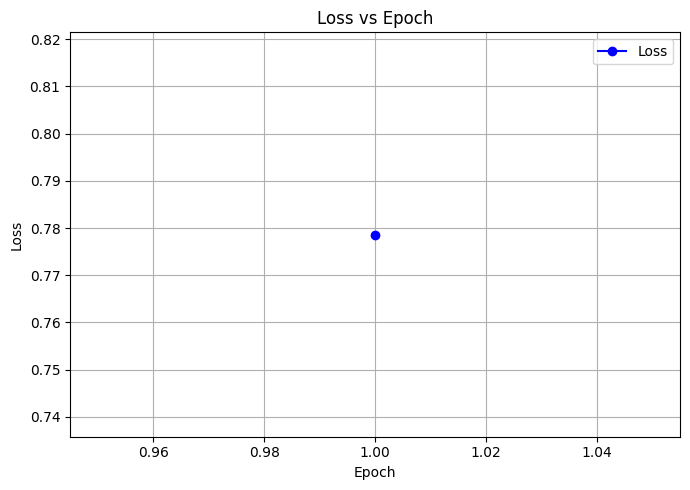

In [31]:
import matplotlib.pyplot as plt
avg_epoch_loss = torch.tensor(avg_epoch_loss, device =  'cpu')
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(avg_epoch_loss) + 1), avg_epoch_loss, label='Loss', color='blue', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [32]:
model.eval()

GeoLocationModel(
  (base_model): CLIPVisionModel(
    (vision_model): CLIPVisionTransformer(
      (embeddings): CLIPVisionEmbeddings(
        (patch_embedding): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
        (position_embedding): Embedding(50, 768)
      )
      (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPEncoderLayer(
            (self_attn): CLIPSdpaAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
       

In [33]:
avg_val_haversine_loss = 0.0
batch_haversine = []

model, optimizer, val_dataloader = accelerator.prepare(model, optimizer, val_dataloader)

with torch.no_grad():  # Disable gradient calculation for validation
    for images, coordinates, image_path in tqdm(val_dataloader, total=len(val_dataloader), desc=f'Validating'):
        # Forward pass
        images, coordinates = images.cuda(), coordinates.cuda()
        outputs = model(images, coordinates, image_path)
        loss_haversine = haversineLoss(outputs['pred'], coordinates).mean(dim=-1)
        batch_haversine.append(loss_haversine)
        avg_val_haversine_loss += loss_haversine

# Calculate average loss and haversine
avg_val_haversine_loss /= len(val_dataloader)

print(f'Validation Haversine Loss: {avg_val_haversine_loss:.4f}')

Validating: 100%|██████████| 313/313 [02:18<00:00,  2.26it/s]


Validation Haversine Loss: 0.7851


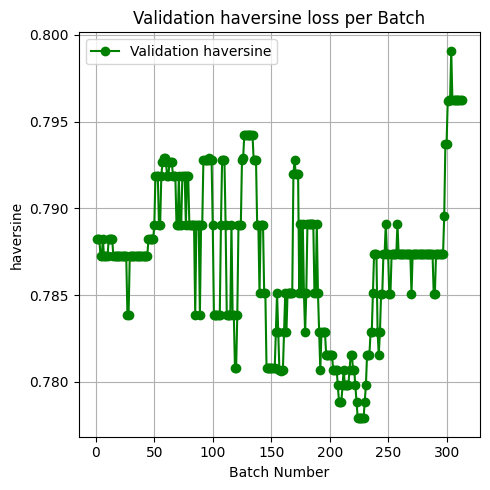

In [34]:
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter

# Back from gpu
batch_haversine = torch.tensor(batch_haversine, device =  'cpu')

# Remove outliers
batch_haversine = median_filter(batch_haversine, size=100)

plt.figure(figsize=(5, 5))
plt.subplot(1, 1, 1)
plt.plot(range(1, len(batch_haversine) + 1), batch_haversine, label='Validation haversine', color='green', marker='o')
plt.xlabel('Batch Number')
plt.ylabel('haversine')
plt.title('Validation haversine loss per Batch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [35]:
from modules.plot import plot_predictions

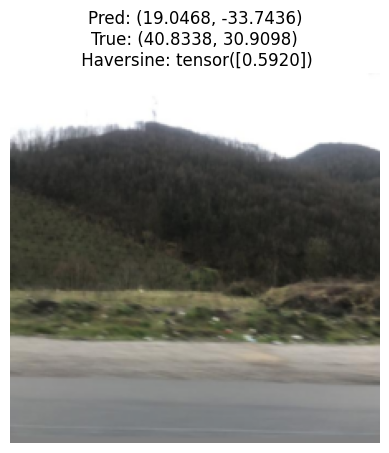

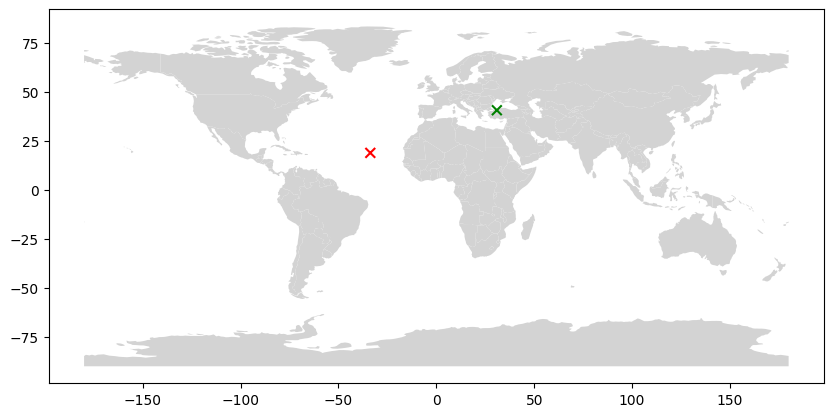

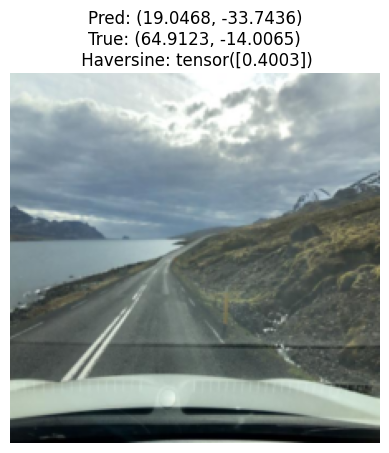

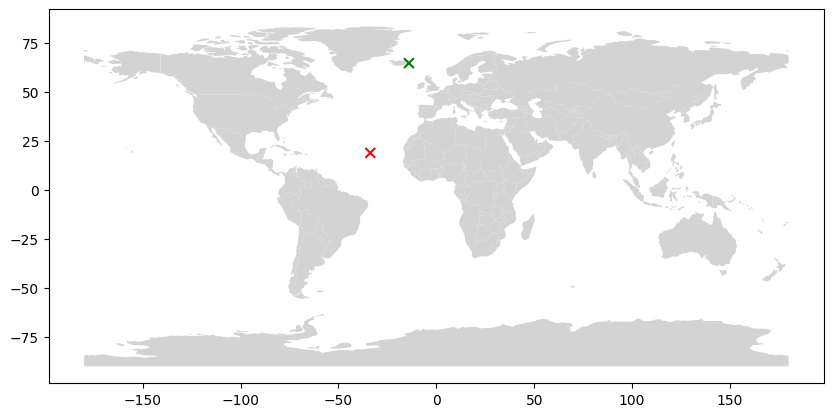

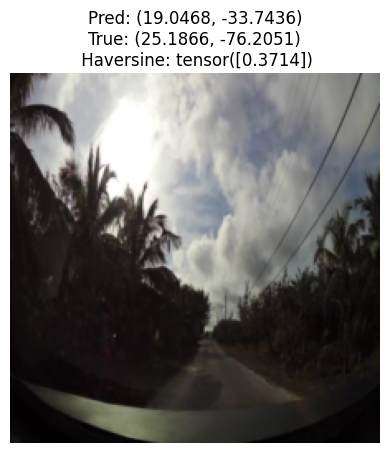

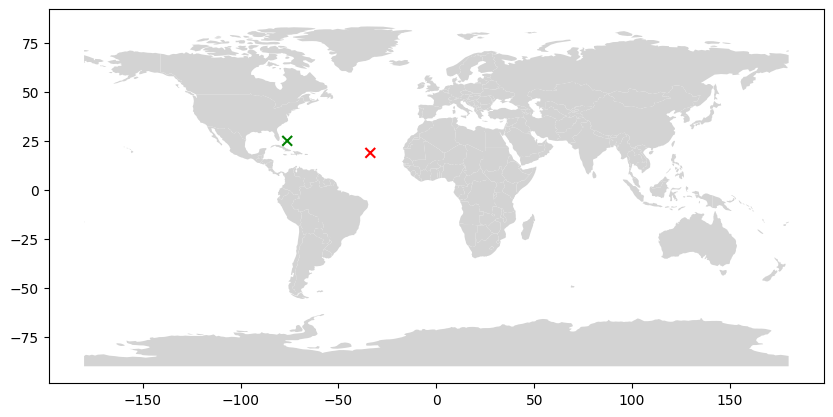

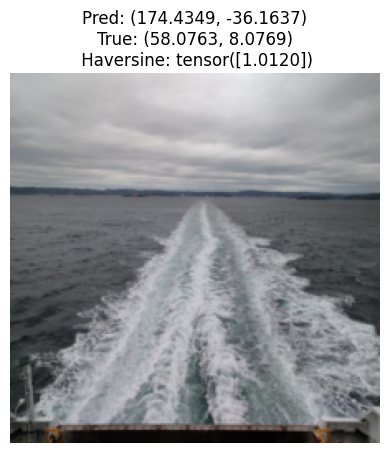

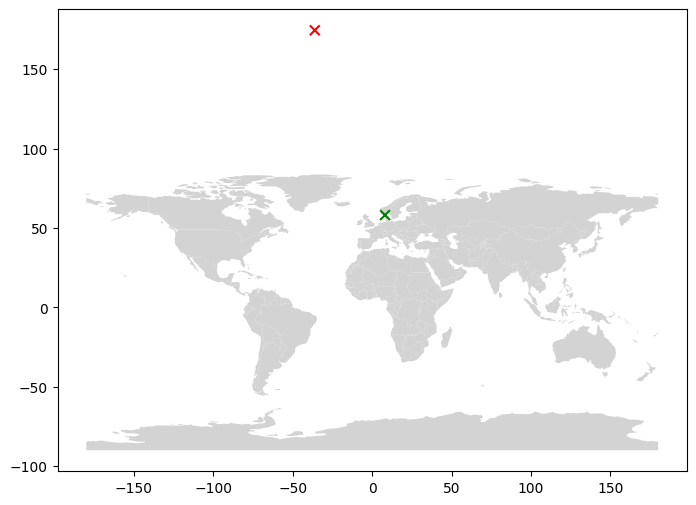

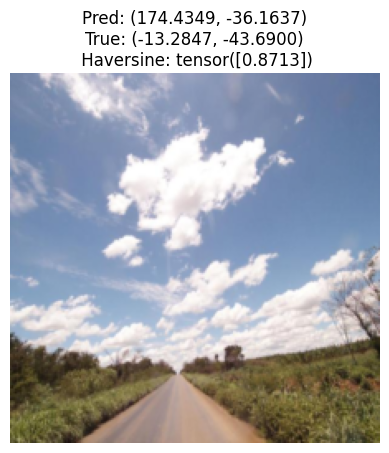

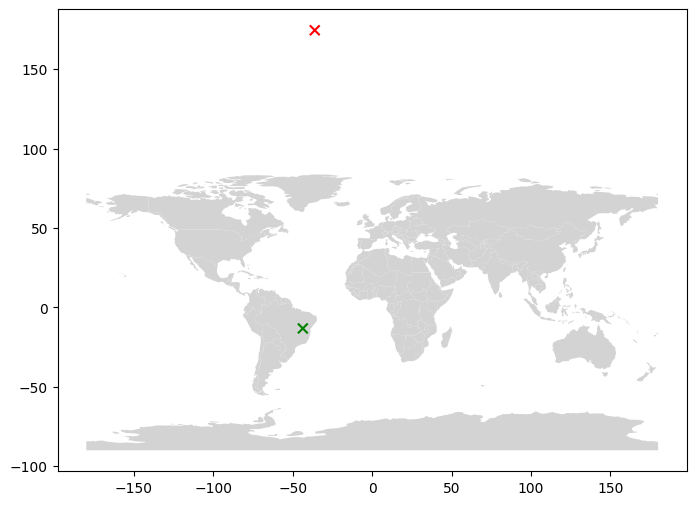

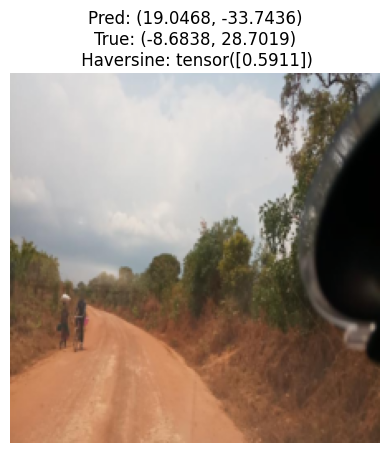

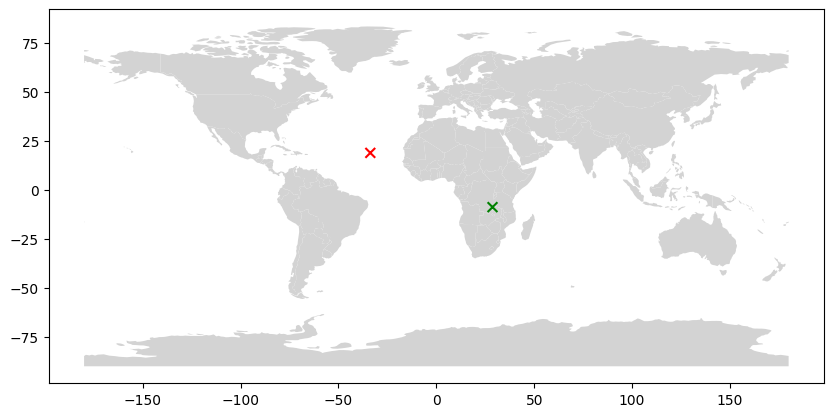

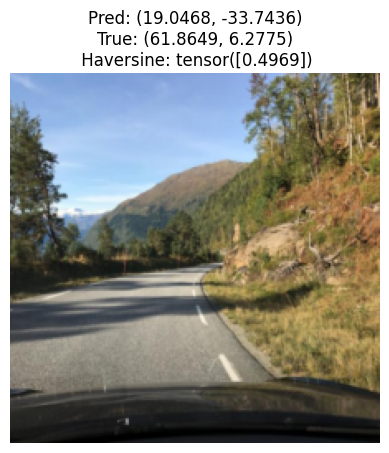

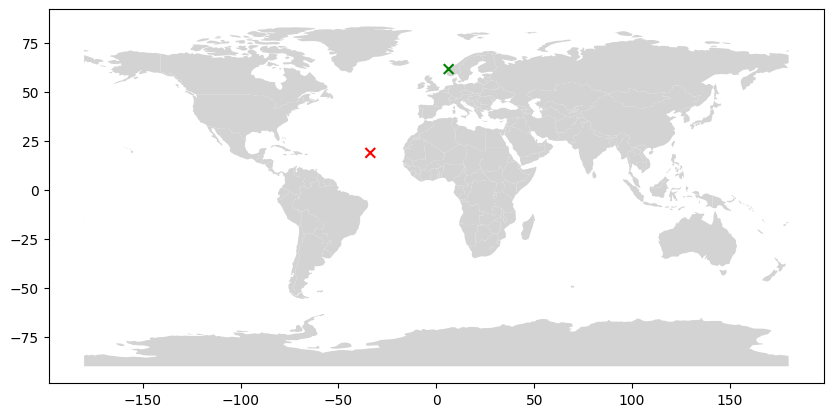

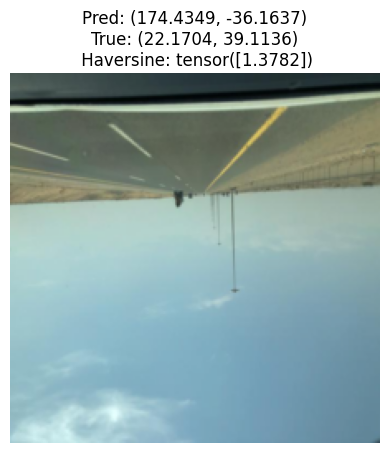

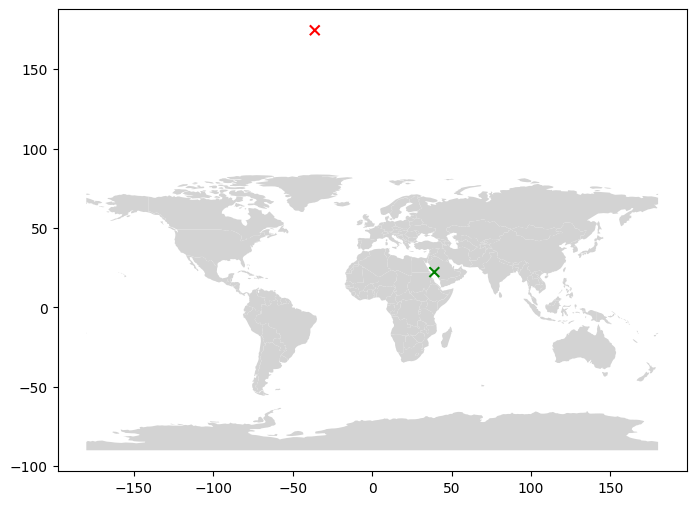

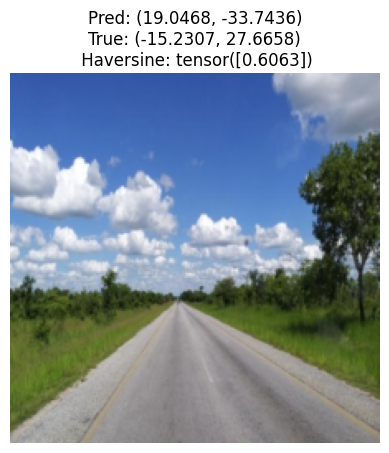

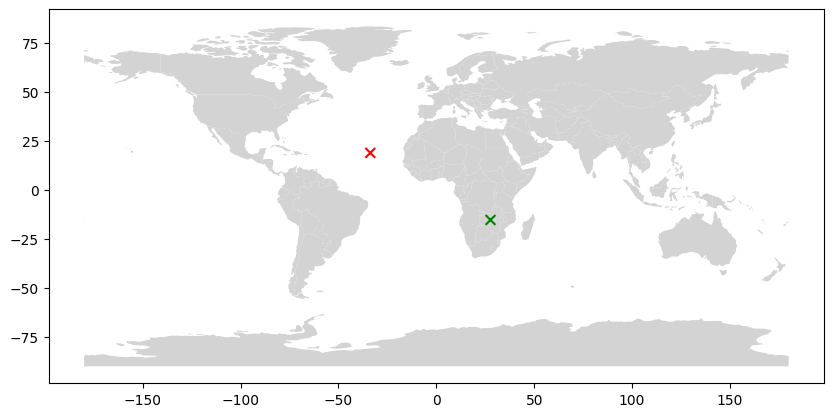

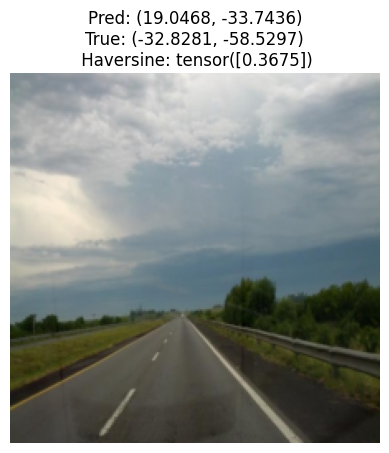

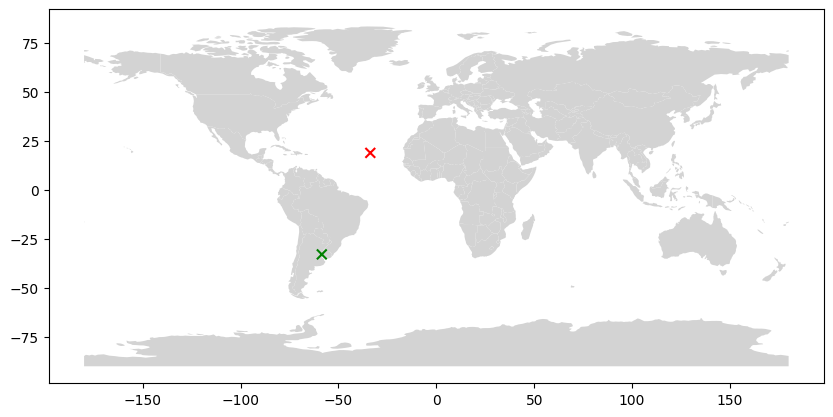

In [36]:
plot_predictions(model, val_dataloader, num_samples=10)